# Pipeline Kmeans y DBscan Run
- Todos Los Modelos Balanceados
-  DATA PREPARATION
-  Constantes modelos pipeline
-  Pipeline
 - OrdinalEncoder
 - ColumnTransformer
 - Seleccion y extracción de de caracteriticas
 - Standard Scaler
- Kmeans
- Dbscan

In [1]:
import numpy as np
import pandas as pd
from sklearn import utils
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
import shap
shap.initjs()
import warnings
warnings.filterwarnings('ignore')

# scikit-learn==1.1.1
# from sinfo import sinfo
# sinfo()
# import sklearn
# sklearn.show_versions()

2023-10-06 15:53:50.849818: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-06 15:53:51.945049: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /anaconda/envs/azureml_py38/lib/python3.8/site-packages/cv2/../../lib64:
2023-10-06 15:53:51.945206: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /anaconda/envs/azureml_py38/lib/python3.8/site-pa

In [2]:
import metricas
from sklearn import metrics
import psutil
import GPUtil
import time

start_time = time.time()
psutil.cpu_times()
psutil.virtual_memory()
psutil.disk_partitions()

t_cpu = psutil.cpu_times()
cpu_usage = psutil.cpu_percent(1)
mem_usage = psutil.virtual_memory().percent
disco2 = psutil.disk_usage('/')

In [3]:
import joblib
import os

def pickle_model(pkl_filename, operation, model):
    if operation == 'wb':
        with open(pkl_filename, operation) as file:
            joblib.dump(model, file)
        print('Modelo', pkl_filename, 'guardado.')
            
    elif operation == 'rb':
        with open(pkl_filename, operation) as file:
            joblib_model =joblib.load(file)
        print('Lectura de', pkl_filename, '.')
        return joblib_model

In [4]:
def new_categories(df,old_keys,new_keys):

    choices = ['DDoS_UDP','Reconnaissance','DDoS_TCP']

    for i,v in enumerate(old_keys):
        condiciones = [
        df[ v ].str.contains('DDoS_UDP|DoS_UDP'),
        df[ v ].str.contains('Reconnaissance_OS_Fingerprint|Reconnaissance_Service_Scan'),
        df[ v ].str.contains('DDoS_TCP|DoS_TCP')
        ]
        df[new_keys[i]] = np.select(condiciones,choices, default='Normal')
        print(df[new_keys[i]].value_counts())

In [5]:
import os
import psutil
import time
import datetime

def cpu_info():
    cpu = psutil.Process(os.getpid()).cpu_percent (1) # tasa de uso de CPU en un segundo, unidad
    cpu_per = '% .2f %%'% cpu # se convierte en un porcentaje, mantenga dos decimales
    return (cpu_per , cpu)

def mem_info():
    mem = psutil.Process(os.getpid()).memory_percent()
    
    mem_per = '%.2f%%' % mem
    return (mem_per , mem)


def disk_info() :
    c_info = psutil.disk_usage('/')
    c_per = '%.2f%%' % c_info[3]
    return c_per


def medida_tiempo() :
    tiempo = datetime.datetime.now()
    return tiempo


def tiempo_total(t1 , t2) :
    t_total = t2 - t1
    return t_total


def children_process(cpu , mem) :
    c_list= []
    children_list = psutil.Process(os.getpid()).children()
    if len(children_list) > 0:
        for i in range( len (children_list) ):
            c_list += [children_list[ i ].pid]
        info_children = add_children(c_list , cpu , mem)
        return info_children
    else:
        return 'Not children'
    


def add_children(c_list , cpu , mem) :
    cpu_su = cpu[1]
    mem_su = mem[1]
    for i in range( len (c_list)):
        pid = c_list[i]
        cpu_child = psutil.Process(pid).cpu_percent (1)
        mem_child = psutil.Process( pid ).memory_percent()
#         print( cpu_child , mem_child )
        cpu_su += cpu_child
        mem_su += mem_child
    cpu_total = '%.2f%%' % cpu_su
    mem_total = '%.2f%%' % mem_su
    return (cpu_total , mem_total)   

def print_info(cpu , mem , disco , t , otro) :
    if otro == 'Not children':
        var_prin = f'cpu: {cpu[0]}, memoria: {mem[0]}, disco: {disco}, tiempo: {t}'
    if otro != 'Not children':
        var_prin = f'cpu: {otro[0]}, memoria: {otro[1]}, disco: {disco}, tiempo: {t}'
    return var_prin

if __name__ == '__main__' :
    t1 = medida_tiempo()
    cpu = cpu_info()
    mem = mem_info()
    disco = disk_info()
    otro = children_process(cpu , mem)
    t2 = medida_tiempo()
    t= tiempo_total(t1, t2)
    print_info(cpu , mem , disco , t , otro)

# DATA PREPARATION

In [6]:
dfs = []
#features_to_keep=['port_src', 'delta_time', 'port_dst', 'ip_ttl', 'frame_len', 'label','tipo_ataque']
for i in range(7):
    path = 'IoT_Dataset_{}_20k.csv'  # There are 4 input csv files
    #dfs.append(pd.read_csv(path.format(i), usecols=features_to_keep, sep='\t',decimal='.',low_memory=False))
    dfs.append(pd.read_csv(path.format(i), sep='\t',decimal='.',low_memory=False))
df = pd.concat(dfs).reset_index(drop=True)  # Concat all to a single df
df =utils.shuffle(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320000 entries, 10340 to 252480
Data columns (total 27 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   delta_time       320000 non-null  float64
 1   protocols        320000 non-null  object 
 2   ip_src           320000 non-null  object 
 3   ip_dst           320000 non-null  object 
 4   port_src         319604 non-null  float64
 5   port_dst         319604 non-null  float64
 6   frame_len        320000 non-null  int64  
 7   udp_len          140165 non-null  float64
 8   ip_ttl           319730 non-null  object 
 9   icmp_type        5529 non-null    float64
 10  tos              319730 non-null  object 
 11  ip_flags_rb      319730 non-null  object 
 12  ip_flags_df      319730 non-null  object 
 13  ip_flags_mf      319730 non-null  object 
 14  tcp_flags_res    179439 non-null  float64
 15  tcp_flags_ns     179439 non-null  float64
 16  tcp_flags_cwr    179439 non-null  

In [16]:
df.tipo_ataque.value_counts()

Normal                           200000
DDoS_TCP                          20000
Reconnaissance_Service_Scan       20000
DoS_TCP                           20000
Reconnaissance_OS_Fingerprint     20000
DDoS_UDP                          20000
DoS_UDP                           20000
Name: tipo_ataque, dtype: int64

In [17]:
df = df.drop(['ip_src', 'ip_dst','epoch_time' ],axis=1) # epoch_time tiempo maquina
lista=['ip_ttl',  'tos','ip_flags_rb','ip_flags_df','ip_flags_mf']
#tipo string, para reemplazar un coma por el punto y convertirlo en float
df[lista] = df[lista].astype('str')
df.ip_ttl = df.ip_ttl.str.replace(',','.')
df.tos = df.tos.str.replace(',','.')
df.ip_flags_rb = df.ip_flags_rb.str.replace(',','.')
df.ip_flags_df = df.ip_flags_df.str.replace(',','.')
df.ip_flags_mf = df.ip_flags_mf.str.replace(',','.')
df[lista] = df[lista].astype('float64')
df[lista].info()
len(df['protocols'].unique())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320000 entries, 10340 to 252480
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   ip_ttl       319730 non-null  float64
 1   tos          319730 non-null  float64
 2   ip_flags_rb  319730 non-null  float64
 3   ip_flags_df  319730 non-null  float64
 4   ip_flags_mf  319730 non-null  float64
dtypes: float64(5)
memory usage: 14.6 MB


35

In [18]:
X = df.drop(['label','tipo_ataque', 'protocols'],axis=1)
y = y =df['label']
X

,delta_time,port_src,port_dst,frame_len,udp_len,ip_ttl,icmp_type,tos,ip_flags_rb,ip_flags_df,...,tcp_flags_res,tcp_flags_ns,tcp_flags_cwr,tcp_flags_ecn,tcp_flags_urg,tcp_flags_ack,tcp_flags_push,tcp_flags_reset,tcp_flags_syn,tcp_flags_fin
10340,0.000003,80.0,80.0,1449,1415.0,127.00,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
208905,0.000084,35008.0,1051.0,70,8.0,64.47,3.0,48.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
299463,0.000001,58470.0,80.0,154,NaN,64.00,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
132215,0.000002,0.0,0.0,1175,NaN,127.00,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
151597,0.000002,80.0,80.0,1216,1182.0,127.00,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196149,0.001708,8080.0,80.0,907,NaN,127.00,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123714,0.000002,80.0,80.0,600,566.0,127.00,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
263138,0.000001,35625.0,80.0,154,NaN,64.00,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
194602,0.000003,80.0,3456.0,771,737.0,127.00,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Constantes modelos pipeline

In [19]:
#EJERCICIO 10

elimina = ['number__tcp_flags_cwr', 'number__tcp_flags_ecn', 
           'number__tcp_flags_urg', 'number__tcp_flags_ack',
           'number__tcp_flags_push', 'number__tcp_flags_reset',
           'number__tcp_flags_fin', 'number__icmp_type',
           'number__ip_flags_rb', 'number__tcp_flags_res']
metodo_scaler= 'scaler'
strategy='constant'
fill_value=-1
# kmeans
n_clusters=29
# pca
n_components= 6
# dbscan
eps= 0.01924652961188758
m_samples= 29

# #EJERCICIO 17

# elimina = ['number__tcp_flags_cwr', 'number__tcp_flags_ecn', 
#            'number__tcp_flags_urg', 'number__tcp_flags_ack',
#            'number__tcp_flags_push', 'number__tcp_flags_reset',
#            'number__tcp_flags_fin', 'number__icmp_type',
#            'number__ip_flags_rb', 'number__tcp_flags_res']
# metodo_scaler= 'scaler'
# strategy='constant'
# fill_value=-1
# n_clusters=7
# n_components= 6
# eps= 0.039984318617935714
# m_samples= 22

In [20]:
print(fill_value)
print(elimina)
print(n_clusters)
print(eps)

-1
['number__tcp_flags_cwr', 'number__tcp_flags_ecn', 'number__tcp_flags_urg', 'number__tcp_flags_ack', 'number__tcp_flags_push', 'number__tcp_flags_reset', 'number__tcp_flags_fin', 'number__icmp_type', 'number__ip_flags_rb', 'number__tcp_flags_res']
29
0.01924652961188758


In [21]:
# PIPELINE
# seleccion de tipo de columna numerico y categorica
numerical_features = X.select_dtypes(include='number').columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()
print(numerical_features)
print(categorical_features)

['delta_time', 'port_src', 'port_dst', 'frame_len', 'udp_len', 'ip_ttl', 'icmp_type', 'tos', 'ip_flags_rb', 'ip_flags_df', 'ip_flags_mf', 'tcp_flags_res', 'tcp_flags_ns', 'tcp_flags_cwr', 'tcp_flags_ecn', 'tcp_flags_urg', 'tcp_flags_ack', 'tcp_flags_push', 'tcp_flags_reset', 'tcp_flags_syn', 'tcp_flags_fin']
[]


In [22]:
numeric_pipeline = Pipeline(steps=[('impute', SimpleImputer(strategy=strategy, fill_value=fill_value))])

In [23]:
## OrdinalEncoder
from sklearn.preprocessing import OrdinalEncoder
categorical_pipeline = Pipeline(steps=[
    ('OrdinalEncoder',OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1))])

## ColumnTransformer

In [24]:
preprocessor_1 = ColumnTransformer(transformers=[('number', numeric_pipeline, numerical_features),
                                                 ('category', categorical_pipeline, categorical_features)])

In [25]:
pp1=preprocessor_1.fit_transform(X)
columns=preprocessor_1.get_feature_names_out().tolist()
# se creand 16 nuevas variables
print(len(columns))
columns

21


['number__delta_time',
 'number__port_src',
 'number__port_dst',
 'number__frame_len',
 'number__udp_len',
 'number__ip_ttl',
 'number__icmp_type',
 'number__tos',
 'number__ip_flags_rb',
 'number__ip_flags_df',
 'number__ip_flags_mf',
 'number__tcp_flags_res',
 'number__tcp_flags_ns',
 'number__tcp_flags_cwr',
 'number__tcp_flags_ecn',
 'number__tcp_flags_urg',
 'number__tcp_flags_ack',
 'number__tcp_flags_push',
 'number__tcp_flags_reset',
 'number__tcp_flags_syn',
 'number__tcp_flags_fin']

In [26]:
pp1 = pd.DataFrame(pp1, index=X.index, columns=columns)
print(pp1.columns)
pp1

Index(['number__delta_time', 'number__port_src', 'number__port_dst',
       'number__frame_len', 'number__udp_len', 'number__ip_ttl',
       'number__icmp_type', 'number__tos', 'number__ip_flags_rb',
       'number__ip_flags_df', 'number__ip_flags_mf', 'number__tcp_flags_res',
       'number__tcp_flags_ns', 'number__tcp_flags_cwr',
       'number__tcp_flags_ecn', 'number__tcp_flags_urg',
       'number__tcp_flags_ack', 'number__tcp_flags_push',
       'number__tcp_flags_reset', 'number__tcp_flags_syn',
       'number__tcp_flags_fin'],
      dtype='object')


,number__delta_time,number__port_src,number__port_dst,number__frame_len,number__udp_len,number__ip_ttl,number__icmp_type,number__tos,number__ip_flags_rb,number__ip_flags_df,...,number__tcp_flags_res,number__tcp_flags_ns,number__tcp_flags_cwr,number__tcp_flags_ecn,number__tcp_flags_urg,number__tcp_flags_ack,number__tcp_flags_push,number__tcp_flags_reset,number__tcp_flags_syn,number__tcp_flags_fin
10340,0.000003,80.0,80.0,1449.0,1415.0,127.00,-1.0,0.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
208905,0.000084,35008.0,1051.0,70.0,8.0,64.47,3.0,48.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
299463,0.000001,58470.0,80.0,154.0,-1.0,64.00,-1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
132215,0.000002,0.0,0.0,1175.0,-1.0,127.00,-1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
151597,0.000002,80.0,80.0,1216.0,1182.0,127.00,-1.0,0.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196149,0.001708,8080.0,80.0,907.0,-1.0,127.00,-1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123714,0.000002,80.0,80.0,600.0,566.0,127.00,-1.0,0.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
263138,0.000001,35625.0,80.0,154.0,-1.0,64.00,-1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
194602,0.000003,80.0,3456.0,771.0,737.0,127.00,-1.0,0.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


## Seleccion y extracción de de caracteriticas

In [27]:
# CREACION DE UNA CONEXION PIPELINE
#  Colocar nombres
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
class del_columns(BaseEstimator, TransformerMixin):
    def __init__(self,columns):
        self.columns=columns
#         print('delect columns,columns')
        
        
    def fit(self, X , y=None):
#         print('fit')
#         print(type(X))
        return self
        
    def transform(self, X , y=None):
#         print('trans')
        X =pd.DataFrame(X, columns=columns)
#         print(X.head(5))

        X_ =X.drop(elimina,axis=1)
#         print(X_.columns)
#         X_= X_.to_numpy()        
        return X_

In [28]:
preprocessor_2 = Pipeline(steps=[('prepro_1_num_cat',preprocessor_1),
                                 ('del_columns',del_columns(columns)),
                                 ])
pp1=preprocessor_2.fit_transform(X)
pp1.index = X.index
pp1

,number__delta_time,number__port_src,number__port_dst,number__frame_len,number__udp_len,number__ip_ttl,number__tos,number__ip_flags_df,number__ip_flags_mf,number__tcp_flags_ns,number__tcp_flags_syn
10340,0.000003,80.0,80.0,1449.0,1415.0,127.00,0.0,0.0,0.0,-1.0,-1.0
208905,0.000084,35008.0,1051.0,70.0,8.0,64.47,48.0,0.0,0.0,-1.0,-1.0
299463,0.000001,58470.0,80.0,154.0,-1.0,64.00,0.0,0.0,0.0,0.0,1.0
132215,0.000002,0.0,0.0,1175.0,-1.0,127.00,0.0,0.0,0.0,0.0,0.0
151597,0.000002,80.0,80.0,1216.0,1182.0,127.00,0.0,0.0,0.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...
196149,0.001708,8080.0,80.0,907.0,-1.0,127.00,0.0,0.0,0.0,0.0,0.0
123714,0.000002,80.0,80.0,600.0,566.0,127.00,0.0,0.0,0.0,-1.0,-1.0
263138,0.000001,35625.0,80.0,154.0,-1.0,64.00,0.0,0.0,0.0,0.0,1.0
194602,0.000003,80.0,3456.0,771.0,737.0,127.00,0.0,0.0,0.0,-1.0,-1.0


## Standard Scaler

In [29]:
# definicion de las conexiones de la tuberia en orden secuencial

preprocessor_3 = Pipeline(steps=[('prepro_2_del',preprocessor_2),
#                                  (metodo_scaler,StandardScaler()),
#                                  ('del_columns',del_columns(columns)),])
                                 (metodo_scaler,StandardScaler()),#])
                                 ('pca', PCA(n_components= n_components))])
# datos para realizar las metricas internas
preprocessor_3.fit(X)
pp3 = preprocessor_3.transform(X)
# #Con PCA
pp3 = pd.DataFrame(pp3, index=X.index)
# #Sin PCA
# pp3 = pd.DataFrame(pp3, index=X.index,columns=pp1.columns)
#DIVISION DE CONJUNTO DE DATOS ENTRENENAMEINTO Y PRUEBAS
X_Train, X_Test, y_Train, y_Test = train_test_split(pp3, y, test_size=0.2, random_state=42)
pp3

,0,1,2,3,4,5
10340,-3.358061,-0.496553,-0.031544,-0.695944,0.316734,-0.648238
208905,1.020481,-4.370952,-1.238257,2.617493,-4.581752,-2.998889
299463,2.703061,0.111313,1.135163,-0.425851,-0.140212,-0.240964
132215,-0.700718,1.527335,0.246689,-0.130277,-0.248283,-0.785916
151597,-2.956058,-0.564629,-0.000887,-0.568674,0.271483,-0.404974
...,...,...,...,...,...,...
196149,-0.307589,1.296184,0.288755,-0.089093,-0.247447,-0.556962
123714,-1.893255,-0.744545,0.080115,-0.232098,0.151824,0.238268
263138,2.195142,0.343523,0.980462,-0.330504,-0.084380,-0.223172
194602,-2.136758,-0.724265,-0.156200,-0.278743,0.234809,0.030561


In [30]:
preprocessor_3 

Pipeline(steps=[('prepro_2_del',
                 Pipeline(steps=[('prepro_1_num_cat',
                                  ColumnTransformer(transformers=[('number',
                                                                   Pipeline(steps=[('impute',
                                                                                    SimpleImputer(fill_value=-1,
                                                                                                  strategy='constant'))]),
                                                                   ['delta_time',
                                                                    'port_src',
                                                                    'port_dst',
                                                                    'frame_len',
                                                                    'udp_len',
                                                                    'ip_ttl',
                                                                    'icmp_type',
                                                                    'tos',
                                                                    'ip_flags_rb',
                                                                    'ip_flags_df',
                                                                    'ip_flags_mf',
                                                                    'tcp_flags_res',
                                                                    'tcp_flags_ns',
                                                                    'tcp...
                                                       'number__ip_flags_rb',
                                                       'number__ip_flags_df',
                                                       'number__ip_flags_mf',
                                                       'number__tcp_flags_res',
                                                       'number__tcp_flags_ns',
                                                       'number__tcp_flags_cwr',
                                                       'number__tcp_flags_ecn',
                                                       'number__tcp_flags_urg',
                                                       'number__tcp_flags_ack',
                                                       'number__tcp_flags_push',
                                                       'number__tcp_flags_reset',
                                                       'number__tcp_flags_syn',
                                                       'number__tcp_flags_fin']))])),
                ('scaler', StandardScaler()), ('pca', PCA(n_components=6))])

# KMeans

In [39]:
kmeans_1 = Pipeline(steps=[('preprocessor_3_pca',preprocessor_3),
                           ('kmeans',KMeans(n_clusters=n_clusters))])

In [40]:
kmeans_1

Pipeline(steps=[('preprocessor_3_pca',
                 Pipeline(steps=[('prepro_2_del',
                                  Pipeline(steps=[('prepro_1_num_cat',
                                                   ColumnTransformer(transformers=[('number',
                                                                                    Pipeline(steps=[('impute',
                                                                                                     SimpleImputer(fill_value=-1,
                                                                                                                   strategy='constant'))]),
                                                                                    ['delta_time',
                                                                                     'port_src',
                                                                                     'port_dst',
                                                                                     'frame_len',
                                                                                     'udp_len',
                                                                                     'ip_ttl',
                                                                                     'icmp_type',
                                                                                     'tos',
                                                                                     'ip_flags_rb',
                                                                                     'ip_flags_df',
                                                                                     'ip_flags_m...
                                                                        'number__ip_flags_mf',
                                                                        'number__tcp_flags_res',
                                                                        'number__tcp_flags_ns',
                                                                        'number__tcp_flags_cwr',
                                                                        'number__tcp_flags_ecn',
                                                                        'number__tcp_flags_urg',
                                                                        'number__tcp_flags_ack',
                                                                        'number__tcp_flags_push',
                                                                        'number__tcp_flags_reset',
                                                                        'number__tcp_flags_syn',
                                                                        'number__tcp_flags_fin']))])),
                                 ('scaler', StandardScaler()),
                                 ('pca', PCA(n_components=6))])),
                ('kmeans', KMeans(n_clusters=29))])

In [41]:
kmeans_1[0].fit_transform(X)

array([[-3.35806059, -0.49655309, -0.03154427, -0.69594448,  0.3167336 ,
        -0.64823843],
       [ 1.02048147, -4.37095219, -1.23825719,  2.61749318, -4.58175233,
        -2.99888851],
       [ 2.70306129,  0.11131327,  1.13516273, -0.42585104, -0.14021239,
        -0.24096436],
       ...,
       [ 2.19514249,  0.3435226 ,  0.9804622 , -0.33050448, -0.0843804 ,
        -0.22317217],
       [-2.13675822, -0.72426462, -0.15620023, -0.27874303,  0.23480918,
         0.03056092],
       [ 0.16585202, -1.63292717,  0.4876367 ,  0.05830867,  0.13603506,
         1.06734196]])

In [42]:
model_ = KMeans(n_clusters=n_clusters)
model_.fit(X_Train) 
y_pred_kmeans = model_.predict(X_Test)

In [43]:
# strategy, n_components, n_clusters ss
from sklearn.ensemble import RandomForestClassifier
df1_1 = pd.DataFrame()
df1=pp1.copy()
for k in range(10):
    print('k   ',{k})
    predictions_1 = kmeans_1.fit_predict(X)
    
    df1['cluster'] =pd.DataFrame(predictions_1, index=X.index)
    df1[['label','tipo_ataque']] = df[['label','tipo_ataque']].copy()    
    df1.head(5)
    # metricas por tipo de ataque
    l=metricas.y(df1,0, n_clusters,'cluster','tipo_ataque')
    metricas.metricas(df1,'tipo_ataque', 'Trans_cluster')
    metricas.metrica_internas(pp3,df1['cluster'])
    
    #metricas.save_csv(df1,pp3, f'{metodo_scaler}_kmeans_{k}_{strategy}_{n_components}_{n_clusters}_{fill_value}_borrar.csv')
    mm= metricas.matriz(df1,'tipo_ataque','Trans_cluster')
    print(mm[0])    
    print(mm[1])  
    df1_1 = pd.concat([df1_1,mm[1].iloc[:,:4], mm[1].iloc[:,-3:]],axis=1)
    #print(metricas. matriz(df1).to_csv(f'{metodo_scaler}_kmeans_{k}_{strategy}_{n_components}_{n_clusters}_{fill_value}_matriz.csv'))

df1_1.columns=[f'{l}_{j}' for j in range(int(len(df1_1.columns)/7)) for l in ['tp','fp','fn','tn','recall','precision','f1']]
df1_1

print('Rendimiento de Gastos Generales:')
print(f"tiempo:--- {time.time() - start_time} Segundos ---")
print('tiempo_cpu', t_cpu)
print('%_cpu', '%.2f%%' % cpu_usage)
print('%_mem', '%.2f%%' % mem_usage)
print ('consumo de disco', '%.2f%%' % disco2[3])

k    {0}
0 Reconnaissance_Service_Scan
1 Normal
2 Normal
3 DDoS_UDP
4 Reconnaissance_Service_Scan
5 DoS_TCP
6 Normal
7 Normal
8 Normal
9 Normal
10 Reconnaissance_Service_Scan
11 DoS_UDP
12 Normal
13 Normal
14 Normal
15 Reconnaissance_OS_Fingerprint
16 Reconnaissance_Service_Scan
17 Normal
18 Reconnaissance_OS_Fingerprint
19 Normal
20 Reconnaissance_Service_Scan
21 Normal
22 Normal
23 Reconnaissance_Service_Scan
24 DDoS_TCP
25 Normal
26 Normal
27 Reconnaissance_Service_Scan
28 Normal
                               precision    recall  f1-score   support

                     DDoS_TCP       0.54      0.56      0.55     20000
                     DDoS_UDP       0.93      0.73      0.82     20000
                      DoS_TCP       0.38      0.52      0.44     20000
                      DoS_UDP       0.78      1.00      0.88     20000
                       Normal       0.99      0.96      0.97    200000
Reconnaissance_OS_Fingerprint       0.56      0.63      0.59     20000
  Reconnaissan

In [44]:
df1.head(5)

,number__delta_time,number__port_src,number__port_dst,number__frame_len,number__udp_len,number__ip_ttl,number__tos,number__ip_flags_df,number__ip_flags_mf,number__tcp_flags_ns,number__tcp_flags_syn,cluster,label,tipo_ataque,Trans_cluster
10340,0.000003,80.0,80.0,1449.0,1415.0,127.00,0.0,0.0,0.0,-1.0,-1.0,9,0,Normal,Normal
208905,0.000084,35008.0,1051.0,70.0,8.0,64.47,48.0,0.0,0.0,-1.0,-1.0,5,1,Reconnaissance_Service_Scan,Reconnaissance_Service_Scan
299463,0.000001,58470.0,80.0,154.0,-1.0,64.00,0.0,0.0,0.0,0.0,1.0,20,1,DoS_TCP,Reconnaissance_OS_Fingerprint
132215,0.000002,0.0,0.0,1175.0,-1.0,127.00,0.0,0.0,0.0,0.0,0.0,11,0,Normal,Normal
151597,0.000002,80.0,80.0,1216.0,1182.0,127.00,0.0,0.0,0.0,-1.0,-1.0,9,0,Normal,Normal


In [45]:
def metrica_internas(pp3,cluster):
    chs = round(metrics.calinski_harabasz_score(pp3, cluster),5)
    dbs = round(metrics.davies_bouldin_score(pp3, cluster),5)
    return (chs,dbs)   

In [46]:
chs,dbs=metricas.metrica_internas(pp3,df1['cluster'])
print(f'Calinski: {chs}')
print(f'Davies: {dbs}')

Calinski: 966018.36215
Davies: 0.61331


In [47]:
# disminucion de ataques de tipos de ataque a categorias
old_keys=['tipo_ataque', 'Trans_cluster']
new_keys=['categoria','Trans_cluster_']

new_categories(df1,old_keys,new_keys)

Normal            200000
DDoS_TCP           40000
Reconnaissance     40000
DDoS_UDP           40000
Name: categoria, dtype: int64
Normal            192063
Reconnaissance     48848
DDoS_UDP           41176
DDoS_TCP           37913
Name: Trans_cluster_, dtype: int64


In [48]:
# metricas generadas por la creación de categorias()
metricas.metricas(df1,'categoria', 'Trans_cluster_')
chs,dbs=metricas.metrica_internas(pp3,df1['cluster'])
print(f'Calinski: {chs}')
print(f'Davies: {dbs}')

#otras mtericas
import psutil
import GPUtil
import matplotlib.pyplot as plt

#t1 = medida_tiempo()
disco = disk_info()

print('Rendimiento de Gastos Generales:')
print(f"tiempo:--- {time.time() - start_time} Segundos ---")
print('tiempo_cpu', t_cpu)
print('%_cpu', '%.2f%%' % cpu_usage)
print('%_mem', '%.2f%%' % mem_usage)
print ('consumo de disco', '%.2f%%' % disco2[3])

                precision    recall  f1-score   support

      DDoS_TCP       0.92      0.87      0.89     40000
      DDoS_UDP       0.97      1.00      0.99     40000
        Normal       0.99      0.96      0.97    200000
Reconnaissance       0.72      0.88      0.79     40000

      accuracy                           0.94    320000
     macro avg       0.90      0.93      0.91    320000
  weighted avg       0.95      0.94      0.94    320000

Purity  0.94091
homogeneity_score:  0.81919
completeness_score:  0.79237
v_measure_score:  0.80556
adjusted_mutual_info_score:  0.80555
Calinski: 966018.36215
Davies: 0.61331
Rendimiento de Gastos Generales:
tiempo:--- 16280.970087528229 Segundos ---
tiempo_cpu scputimes(user=288.8, nice=452.9, system=512.32, idle=15134.9, iowait=199.64, irq=0.0, softirq=25.6, steal=0.0, guest=0.0, guest_nice=0.0)
%_cpu 6.50%
%_mem 7.20%
consumo de disco 46.50%


In [49]:
mm= metricas.matriz(df1,'categoria','Trans_cluster_')
print(mm[0])    
print(mm[1])  


Normal
         Positive Negative
Positive   191034     8966
Negative     1029   118971

DDoS_TCP
         Positive Negative
Positive    34792     5208
Negative     3121   276879

Reconnaissance
         Positive Negative
Positive    35270     4730
Negative    13578   266422

DDoS_UDP
         Positive Negative
Positive    39995        5
Negative     1181   278819
  Cantidad coincidencia % prediccion total prediciones
0   200000       191034      0.95517            192063
1   120000       118971     0.991425            127937
                    tp     fp    fn      tn   tp+fn   tp+fp   fn+tn   fp+tn  \
Normal          191034   1029  8966  118971  200000  192063  127937  120000   
DDoS_TCP         34792   3121  5208  276879   40000   37913  282087  280000   
Reconnaissance   35270  13578  4730  266422   40000   48848  271152  280000   
DDoS_UDP         39995   1181     5  278819   40000   41176  278824  280000   

                  recall precision        F1  
Normal           0.95517

In [50]:
## guarda lista para aplicacion

l=metricas.y(df1.drop(['Trans_cluster'],axis=1),0, n_clusters,'cluster','categoria')
with open('list_kmeans_over.txt','w') as f:
    f.write(str(l))

0 Normal
1 Normal
2 DDoS_TCP
3 Normal
4 Normal
5 Reconnaissance
6 Normal
7 Reconnaissance
8 Reconnaissance
9 Normal
10 DDoS_UDP
11 Normal
12 Normal
13 Reconnaissance
14 Normal
15 Normal
16 Reconnaissance
17 Normal
18 Normal
19 Reconnaissance
20 Reconnaissance
21 Normal
22 Reconnaissance
23 Normal
24 DDoS_UDP
25 Normal
26 Normal
27 Reconnaissance
28 Normal


In [51]:
# guarda modelo pickle
print('= = ='*10,'12. Guardar el Modelo KMeans ')
pickle_model('kmeans1__EJERCICIO10_n_components6_over.pkl', 'wb', kmeans_1)

= = == = == = == = == = == = == = == = == = == = = 12. Guardar el Modelo KMeans 
Modelo kmeans1__EJERCICIO10_n_components6_over.pkl guardado.


In [52]:
#Guardar datos y prediciones en archivo csv
#df1.to_csv('Kmeans_EJERCICIO10_over_.csv') 

In [53]:
# metricas por tipo ataque
df1['Trans_cluster'].value_counts()

Normal                           192063
DDoS_TCP                          37913
Reconnaissance_OS_Fingerprint     33089
DoS_UDP                           25515
Reconnaissance_Service_Scan       15759
DDoS_UDP                          15661
Name: Trans_cluster, dtype: int64

In [54]:
# metricas por categoria
df1['Trans_cluster_'].value_counts()

Normal            192063
Reconnaissance     48848
DDoS_UDP           41176
DDoS_TCP           37913
Name: Trans_cluster_, dtype: int64

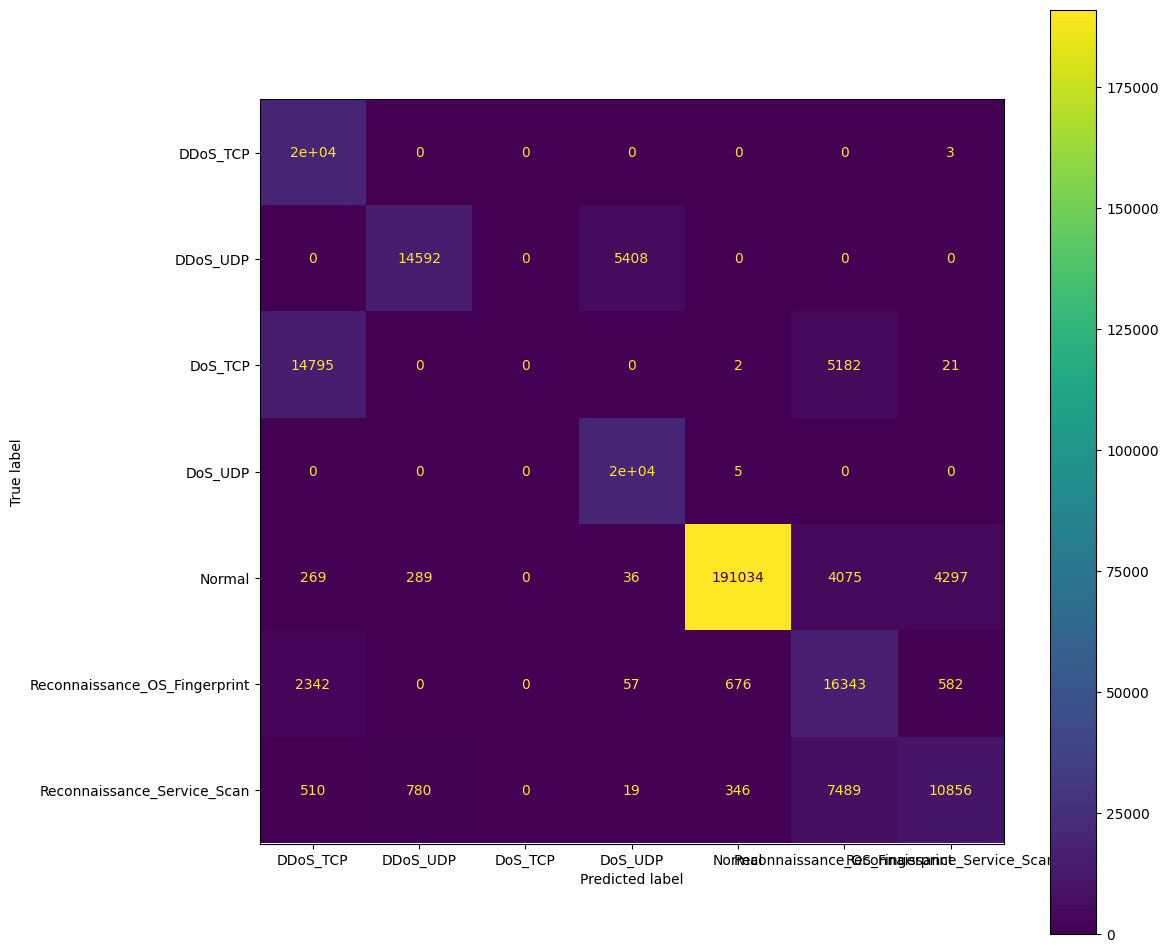

In [55]:
# metricas por tipo de ataque
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
la_matriz=['DDoS_TCP','DDoS_UDP','DoS_TCP','DoS_UDP','Normal','Reconnaissance_OS_Fingerprint','Reconnaissance_Service_Scan']
cm=confusion_matrix(df1['tipo_ataque'], df1['Trans_cluster'])
disp = ConfusionMatrixDisplay(cm,display_labels=la_matriz)
fig, ax = plt.subplots(figsize=(12,12))
disp.plot(ax=ax)

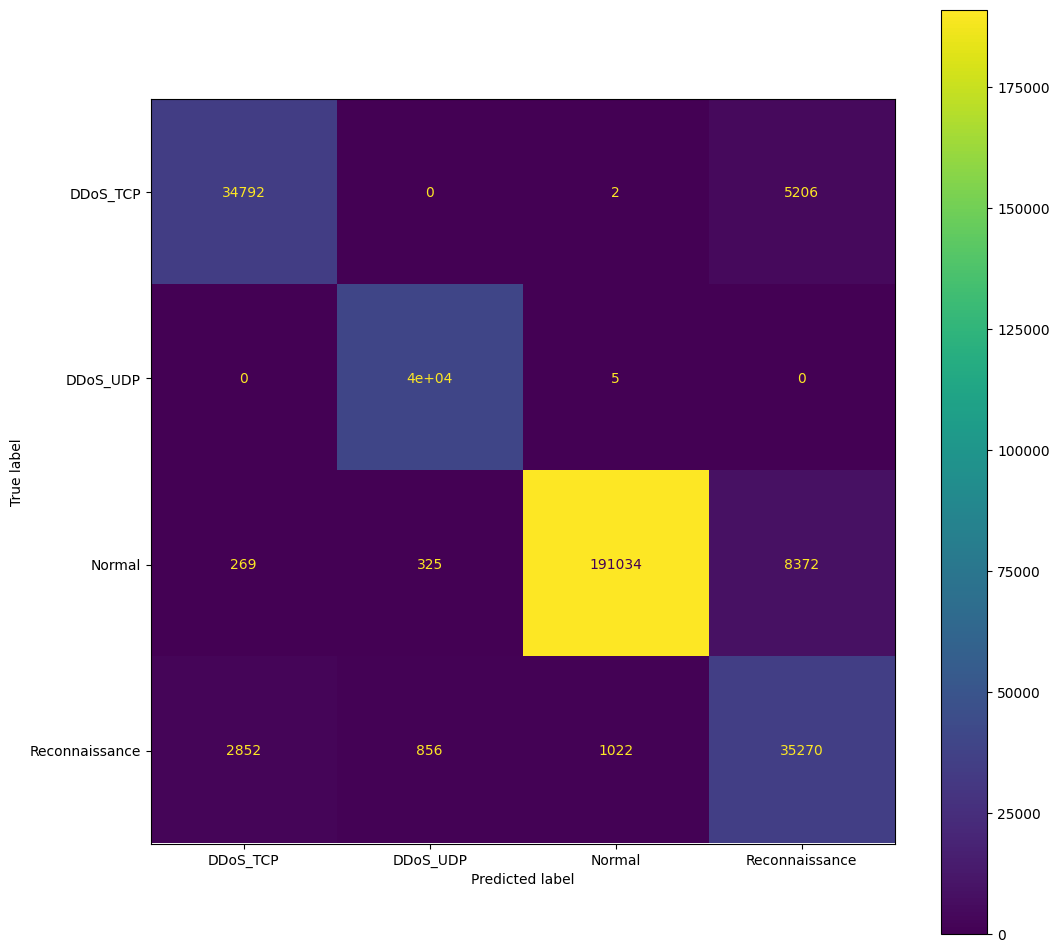

In [56]:
# metricas por categoria
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
la_matriz=['DDoS_TCP','DDoS_UDP','Normal','Reconnaissance']
cm=confusion_matrix(df1['categoria'], df1['Trans_cluster_'])
disp = ConfusionMatrixDisplay(cm,display_labels=la_matriz)
fig, ax = plt.subplots(figsize=(12,12))
disp.plot(ax=ax)

In [57]:
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1200 

# Explicabilidad Kmeans

In [59]:
# Produce the SHAP values kmeans
kmeans_explainer = shap.KernelExplainer(model_.predict,X_Test.sample(500))

Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [60]:
kmeans_shap_values = kmeans_explainer.shap_values(X_Test.sample(500))

  0%|          | 0/500 [00:00<?, ?it/s]

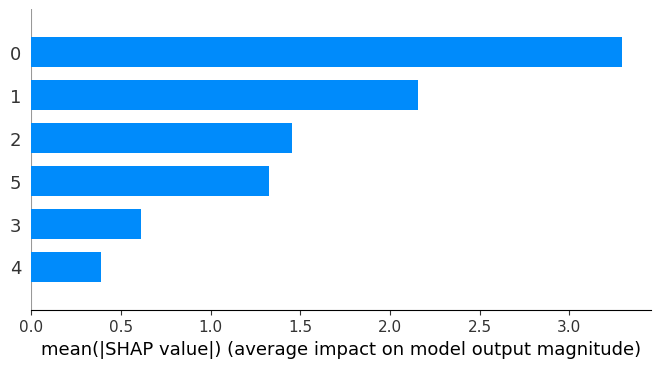

In [61]:
# Primera forma de visualizar los SHAP values kMeans
shap.summary_plot(kmeans_shap_values, X_Test, plot_type='bar')

In [62]:
pd.DataFrame(kmeans_shap_values, columns=X_Train.columns)[0].abs().mean()

3.2916799999999995

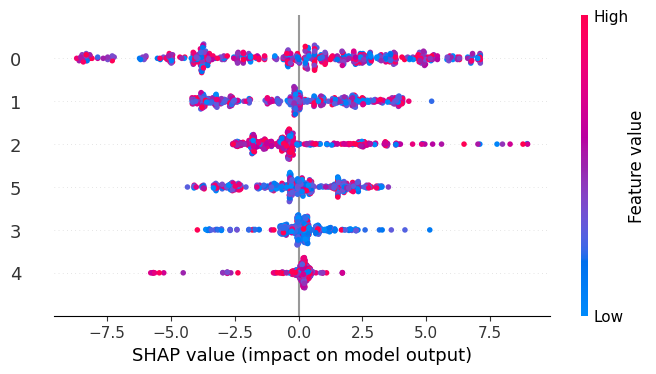

In [63]:
#Segunda Forma de Calcular los SHAP values Kmeans
shap.summary_plot(kmeans_shap_values, X_Test.sample(500))

In [ ]:
# # organizacion excel
# pp1_ = pd.concat([pp1,df['protocols'],df1[['label','tipo_ataque','Trans_cluster','cluster']]],axis=1)
# pp1_

In [ ]:
# pp1_ = pd.concat([pp1,df['protocols'],df1[['label','tipo_ataque','Trans_cluster','cluster']]],axis=1)

# d=['min','max','count']
# ata=la_matriz[0]

# c_olumn =['number__delta_time', 'number__port_src', 'number__port_dst', 'number__frame_len', 'number__udp_len', 'number__ip_ttl',
#           'number__tos', 'number__ip_flags_df', 'number__ip_flags_mf', 'number__tcp_flags_ns', 'number__tcp_flags_syn',
#           'category__protocols','Trans_cluster','cluster','tipo_ataque','label','protocols']
# a0=pp1_[['number__delta_time', 'number__port_src', 'number__port_dst', 'number__frame_len', 'number__udp_len', 'number__ip_ttl',
#          'number__tos', 'number__ip_flags_df', 'number__ip_flags_mf', 'number__tcp_flags_ns', 'number__tcp_flags_syn',
#          'category__protocols','Trans_cluster','cluster','tipo_ataque','label','protocols']][pp1_['Trans_cluster']==ata].groupby(['cluster','tipo_ataque']).agg({ i:{'min','max','count'} for i in c_olumn}).T
# b0=pp1_[['number__delta_time', 'number__port_src', 'number__port_dst', 'number__frame_len', 'number__udp_len', 'number__ip_ttl',
#          'number__tos', 'number__ip_flags_df', 'number__ip_flags_mf', 'number__tcp_flags_ns', 'number__tcp_flags_syn',
#          'category__protocols','Trans_cluster','cluster','tipo_ataque','label','protocols']].groupby(['tipo_ataque']).agg({ i:d for i in c_olumn}).T
# pd.concat([b0.loc[:,ata],a0,],axis=1)

In [ ]:
# pp1_[pp1_['cluster']==5]['category__protocols'].value_counts()

# DBscan

In [64]:
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import DBSCAN
from matplotlib import pyplot
dbscan_1 = Pipeline(steps=[('preprocessor_3_pca',preprocessor_3),
                           ('dbscan',DBSCAN(eps=eps, min_samples= m_samples))])

In [65]:
dbscan_1.fit(X)

Pipeline(steps=[('preprocessor_3_pca',
                 Pipeline(steps=[('prepro_2_del',
                                  Pipeline(steps=[('prepro_1_num_cat',
                                                   ColumnTransformer(transformers=[('number',
                                                                                    Pipeline(steps=[('impute',
                                                                                                     SimpleImputer(fill_value=-1,
                                                                                                                   strategy='constant'))]),
                                                                                    ['delta_time',
                                                                                     'port_src',
                                                                                     'port_dst',
                                                                                     'frame_len',
                                                                                     'udp_len',
                                                                                     'ip_ttl',
                                                                                     'icmp_type',
                                                                                     'tos',
                                                                                     'ip_flags_rb',
                                                                                     'ip_flags_df',
                                                                                     'ip_flags_m...
                                                                        'number__tcp_flags_res',
                                                                        'number__tcp_flags_ns',
                                                                        'number__tcp_flags_cwr',
                                                                        'number__tcp_flags_ecn',
                                                                        'number__tcp_flags_urg',
                                                                        'number__tcp_flags_ack',
                                                                        'number__tcp_flags_push',
                                                                        'number__tcp_flags_reset',
                                                                        'number__tcp_flags_syn',
                                                                        'number__tcp_flags_fin']))])),
                                 ('scaler', StandardScaler()),
                                 ('pca', PCA(n_components=6))])),
                ('dbscan', DBSCAN(eps=0.01924652961188758, min_samples=29))])

In [66]:
# con duplicados
predictions_2 = dbscan_1.fit_predict(X)
df2=pp1.copy()

predictions_2 = dbscan_1.fit_predict(X)
df2=pp1.copy()

# metricas por tipo de ataque
df2['cluster'] =pd.DataFrame(predictions_2, index=X.index)
df2[['label','tipo_ataque']] = df[['label','tipo_ataque']].copy()
df2.head(5)
metricas.y(df2, -1,max(df2['cluster']+1),'cluster','tipo_ataque')
metricas.metricas(df2,'tipo_ataque', 'Trans_cluster')
metricas.metrica_internas(pp3,df2['cluster'])
matriz=metricas. matriz(df2,'tipo_ataque', 'Trans_cluster')
chs,dbs=metricas.metrica_internas(pp3,df2['cluster'])
print(f'Calinski: {chs}')
print(f'Davies: {dbs}')
print(matriz[0])
print(matriz[1])
max(df2['cluster'])

print('Rendimiento de Gastos Generales:')
print(f"tiempo:--- {time.time() - start_time} Segundos ---")
print('tiempo_cpu', t_cpu)
print('%_cpu', '%.2f%%' % cpu_usage)
print('%_mem', '%.2f%%' % mem_usage)
print ('consumo de disco', '%.2f%%' % disco2[3])

-1 Normal
0 Normal
1 Reconnaissance_Service_Scan
2 DoS_TCP
3 Normal
4 Normal
5 Normal
6 Normal
7 Normal
8 Reconnaissance_OS_Fingerprint
9 Normal
10 Normal
11 Normal
12 Normal
13 Normal
14 Normal
15 DDoS_UDP
16 DoS_UDP
17 Normal
18 Normal
19 DDoS_TCP
20 Reconnaissance_OS_Fingerprint
21 Normal
22 Normal
23 Normal
24 Normal
25 Normal
26 Normal
27 Normal
28 Normal
29 Normal
30 Normal
31 DoS_TCP
32 Normal
33 Normal
34 Normal
35 Reconnaissance_Service_Scan
36 Normal
37 Normal
38 Normal
39 Normal
40 Normal
41 Normal
42 Normal
43 Normal
44 Normal
45 Normal
46 Normal
47 Normal
48 Normal
49 Normal
50 Normal
51 Normal
52 Normal
53 Normal
54 Normal
55 Normal
56 Normal
57 DDoS_UDP
58 Normal
59 Normal
60 Normal
61 Normal
62 Normal
63 Normal
64 Normal
65 Normal
66 Normal
67 Normal
68 Reconnaissance_Service_Scan
69 Normal
70 Normal
71 Normal
72 Normal
73 Normal
74 Normal
75 Normal
76 Normal
77 Normal
78 Normal
79 Normal
80 Normal
81 Normal
82 Normal
83 Normal
84 Normal
85 Normal
86 Normal
87 Normal
88

In [67]:
matriz[1]

,tp,fp,fn,tn,tp+fn,tp+fp,fn+tn,fp+tn,recall,precision,F1
Normal,197307,29262,2693,90738,200000,226569,93431,120000,0.986535,0.870847,0.925088
DDoS_TCP,19904,10742,96,289258,20000,30646,289354,300000,0.9952,0.649481,0.786005
Reconnaissance_Service_Scan,6043,3256,13957,296744,20000,9299,310701,300000,0.30215,0.649855,0.412506
DoS_TCP,9157,0,10843,300000,20000,9157,310843,300000,0.45785,1,0.628117
Reconnaissance_OS_Fingerprint,3150,1334,16850,298666,20000,4484,315516,300000,0.1575,0.702498,0.257311
DDoS_UDP,14546,1,5454,299999,20000,14547,305453,300000,0.7273,0.999931,0.842099
DoS_UDP,19905,5393,95,294607,20000,25298,294702,300000,0.99525,0.786821,0.878847


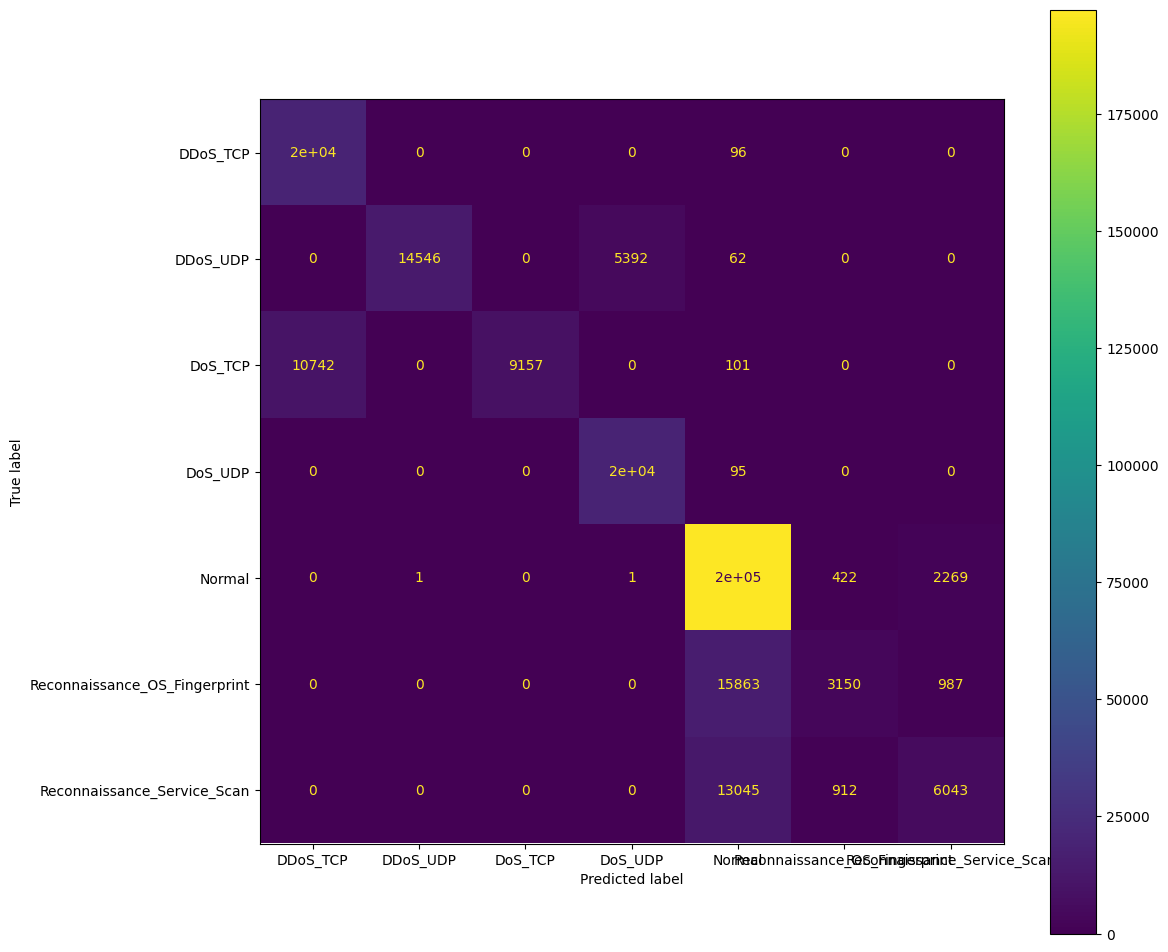

In [68]:
# metricas por tipo de ataque
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
la_matriz=['DDoS_TCP','DDoS_UDP','DoS_TCP','DoS_UDP','Normal','Reconnaissance_OS_Fingerprint','Reconnaissance_Service_Scan']
cm=confusion_matrix(df2['tipo_ataque'], df2['Trans_cluster'])
disp = ConfusionMatrixDisplay(cm,display_labels=la_matriz)
fig, ax = plt.subplots(figsize=(12,12))
disp.plot(ax=ax)

In [69]:
# disminucion de ataques de tipos de ataque a categorias
old_keys=['tipo_ataque', 'Trans_cluster']
new_keys=['categoria','Trans_cluster_']

new_categories(df2,old_keys,new_keys)

Normal            200000
DDoS_TCP           40000
Reconnaissance     40000
DDoS_UDP           40000
Name: categoria, dtype: int64
Normal            226569
DDoS_UDP           39845
DDoS_TCP           39803
Reconnaissance     13783
Name: Trans_cluster_, dtype: int64


In [70]:
pp3

,0,1,2,3,4,5
10340,-3.358061,-0.496553,-0.031544,-0.695944,0.316734,-0.648238
208905,1.020481,-4.370952,-1.238257,2.617493,-4.581752,-2.998889
299463,2.703061,0.111313,1.135163,-0.425851,-0.140212,-0.240964
132215,-0.700718,1.527335,0.246689,-0.130277,-0.248283,-0.785916
151597,-2.956058,-0.564629,-0.000887,-0.568674,0.271483,-0.404974
...,...,...,...,...,...,...
196149,-0.307589,1.296184,0.288755,-0.089093,-0.247447,-0.556962
123714,-1.893255,-0.744545,0.080115,-0.232098,0.151824,0.238268
263138,2.195142,0.343523,0.980462,-0.330504,-0.084380,-0.223172
194602,-2.136758,-0.724265,-0.156200,-0.278743,0.234809,0.030561


In [71]:
# metricas por categoria
metricas.metricas(df2,'categoria', 'Trans_cluster_')
chs,dbs=metricas.metrica_internas(pp3,df2['cluster'])
print(f'Calinski: {chs}')
print(f'Davies: {dbs}')
matriz=metricas. matriz(df2,'categoria', 'Trans_cluster_')
print(matriz[0])
print(matriz[1])
# print(matriz[1])
max(df2['cluster'])


#otras metricas
import psutil
import GPUtil
import matplotlib.pyplot as plt

print('Rendimiento de Gastos Generales:')
print(f"tiempo:--- {time.time() - start_time} Segundos ---")
print('tiempo_cpu', t_cpu)
print('%_cpu', '%.2f%%' % cpu_usage)
print('%_mem', '%.2f%%' % mem_usage)
print ('consumo de disco', '%.2f%%' % disco2[3])

                precision    recall  f1-score   support

      DDoS_TCP       1.00      1.00      1.00     40000
      DDoS_UDP       1.00      1.00      1.00     40000
        Normal       0.87      0.99      0.93    200000
Reconnaissance       0.80      0.28      0.41     40000

      accuracy                           0.90    320000
     macro avg       0.92      0.81      0.83    320000
  weighted avg       0.89      0.90      0.88    320000

Purity  0.90014
homogeneity_score:  0.72008
completeness_score:  0.86028
v_measure_score:  0.78396
adjusted_mutual_info_score:  0.78396
Calinski: 3503.71929
Davies: 1.07884

Normal
         Positive Negative
Positive   197307     2693
Negative    29262    90738

DDoS_TCP
         Positive Negative
Positive    39803      197
Negative        0   280000

Reconnaissance
         Positive Negative
Positive    11092    28908
Negative     2691   277309

DDoS_UDP
         Positive Negative
Positive    39843      157
Negative        2   279998
  Cantid

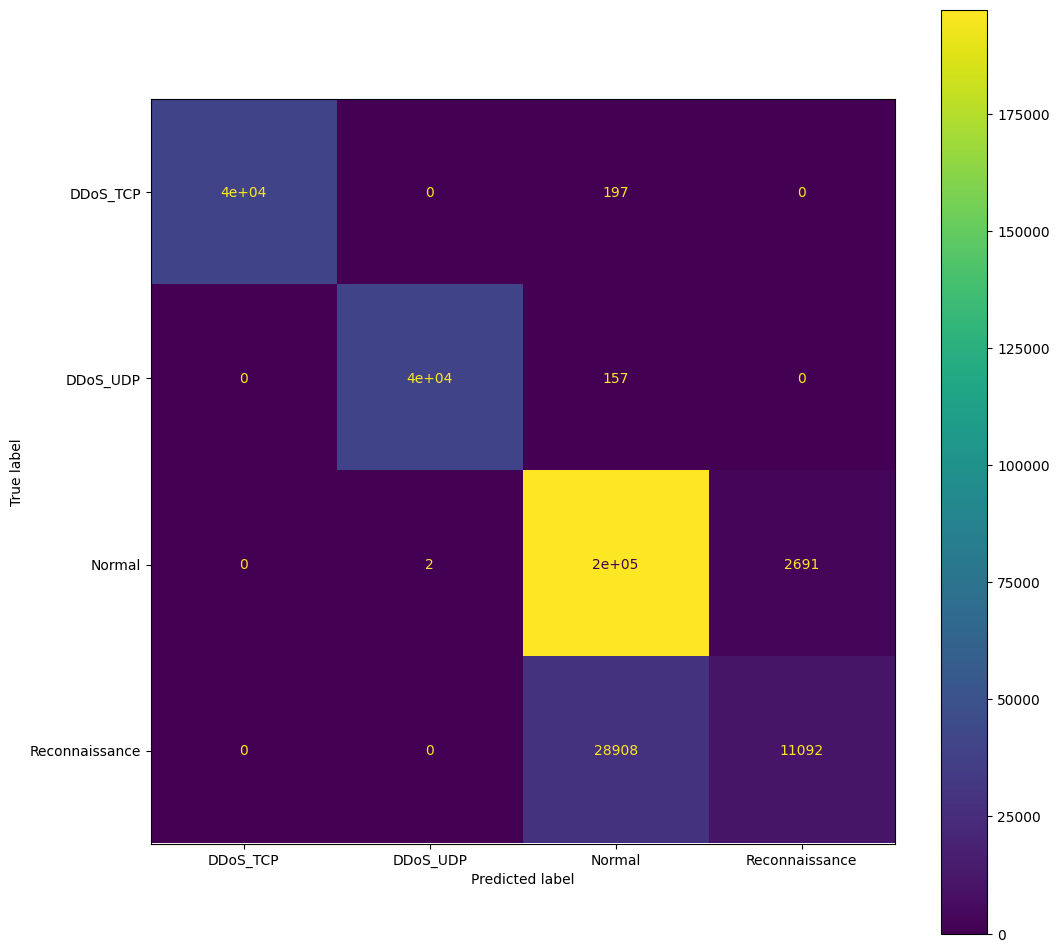

In [72]:
# metricas por tipo de ataque
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
la_matriz=['DDoS_TCP','DDoS_UDP','Normal','Reconnaissance']
cm=confusion_matrix(df2['categoria'], df2[ 'Trans_cluster_'])
disp = ConfusionMatrixDisplay(cm,display_labels=la_matriz)
fig, ax = plt.subplots(figsize=(12,12))
disp.plot(ax=ax)

In [73]:
# guarda lista para aplicacion

l=metricas.y(df2.drop(['Trans_cluster'],axis=1),-1, max(df2['cluster']+1),'cluster','categoria')
with open('list_dbscan2_over.txt','w') as f:
    f.write(str(l))

-1 Reconnaissance
0 Normal
1 Reconnaissance
2 DDoS_TCP
3 Normal
4 Normal
5 Normal
6 Normal
7 Normal
8 Reconnaissance
9 Normal
10 Normal
11 Normal
12 Normal
13 Normal
14 Normal
15 DDoS_UDP
16 DDoS_UDP
17 Normal
18 Normal
19 DDoS_TCP
20 Reconnaissance
21 Normal
22 Normal
23 Normal
24 Normal
25 Normal
26 Normal
27 Normal
28 Normal
29 Normal
30 Normal
31 DDoS_TCP
32 Normal
33 Normal
34 Normal
35 Reconnaissance
36 Normal
37 Normal
38 Normal
39 Normal
40 Normal
41 Normal
42 Normal
43 Normal
44 Normal
45 Normal
46 Normal
47 Normal
48 Normal
49 Normal
50 Normal
51 Normal
52 Normal
53 Normal
54 Normal
55 Normal
56 Normal
57 DDoS_UDP
58 Normal
59 Normal
60 Normal
61 Normal
62 Normal
63 Normal
64 Normal
65 Normal
66 Normal
67 Normal
68 Reconnaissance
69 Normal
70 Normal
71 Normal
72 Normal
73 Normal
74 Normal
75 Normal
76 Normal
77 Normal
78 Normal
79 Normal
80 Normal
81 Normal
82 Normal
83 Normal
84 Normal
85 Normal
86 Normal
87 Normal
88 Normal
89 Normal
90 Normal
91 Normal
92 Normal
93 Normal


In [74]:
print('= = ='*10,'12. Guardar el Modelo KMeans ')
pickle_model('dbscan__EJERCICIO10_n_components6_fit_over.pkl', 'wb', dbscan_1)

= = == = == = == = == = == = == = == = == = == = = 12. Guardar el Modelo KMeans 
Modelo dbscan__EJERCICIO10_n_components6_fit_over.pkl guardado.


In [75]:
#23/11
#'list_dbscan2.txt' 'list_dbscan2.txt'
#dbscan_EJERCICIO10_.csv 

# df2.to_csv('dbscan_EJERCICIO10_.csv')

# Local outlier factor

In [76]:
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.neighbors import LocalOutlierFactor
from matplotlib import pyplot
lof_1 = Pipeline(steps=[('preprocessor_3_pca',preprocessor_3),
                           ('lof',LocalOutlierFactor(novelty=True))])
lof_1

Pipeline(steps=[('preprocessor_3_pca',
                 Pipeline(steps=[('prepro_2_del',
                                  Pipeline(steps=[('prepro_1_num_cat',
                                                   ColumnTransformer(transformers=[('number',
                                                                                    Pipeline(steps=[('impute',
                                                                                                     SimpleImputer(fill_value=-1,
                                                                                                                   strategy='constant'))]),
                                                                                    ['delta_time',
                                                                                     'port_src',
                                                                                     'port_dst',
                                                                                     'frame_len',
                                                                                     'udp_len',
                                                                                     'ip_ttl',
                                                                                     'icmp_type',
                                                                                     'tos',
                                                                                     'ip_flags_rb',
                                                                                     'ip_flags_df',
                                                                                     'ip_flags_m...
                                                                        'number__ip_flags_mf',
                                                                        'number__tcp_flags_res',
                                                                        'number__tcp_flags_ns',
                                                                        'number__tcp_flags_cwr',
                                                                        'number__tcp_flags_ecn',
                                                                        'number__tcp_flags_urg',
                                                                        'number__tcp_flags_ack',
                                                                        'number__tcp_flags_push',
                                                                        'number__tcp_flags_reset',
                                                                        'number__tcp_flags_syn',
                                                                        'number__tcp_flags_fin']))])),
                                 ('scaler', StandardScaler()),
                                 ('pca', PCA(n_components=6))])),
                ('lof', LocalOutlierFactor(novelty=True))])

In [77]:
ind_train = df.loc[df['tipo_ataque'] == 'Normal'].index
cantidad = len(ind_train)*0.6
ind_train = ind_train[:int(cantidad)]

#print(cantidad)
X_train= df.loc[df['tipo_ataque'] == 'Normal'].head(int(cantidad)).drop(['label','tipo_ataque'],axis=1)
print(X_train.tail(5))
y_train = df.loc[df['tipo_ataque'] == 'Normal'].head(int(cantidad))['label']
print(y_train)

        delta_time protocols  port_src  port_dst  frame_len  udp_len  ip_ttl  \
131139    0.046537       TCP      80.0    8080.0        669      NaN   127.0   
170530    0.046591       TCP      80.0    8080.0       1077      NaN   127.0   
42920     0.000004       TCP   62169.0    8180.0         60      NaN    59.0   
166298    0.000002       UDP      80.0      80.0        730    696.0   127.0   
106065    0.000010       TCP    8080.0      80.0       1398      NaN   127.0   

        icmp_type  tos  ip_flags_rb  ip_flags_df  ip_flags_mf  tcp_flags_res  \
131139        NaN  0.0          0.0          0.0          0.0            0.0   
170530        NaN  0.0          0.0          0.0          0.0            0.0   
42920         NaN  0.0          0.0          0.0          0.0            0.0   
166298        NaN  0.0          0.0          0.0          0.0            NaN   
106065        NaN  0.0          0.0          0.0          0.0            0.0   

        tcp_flags_ns  tcp_flags_cwr  t

In [78]:
last_ind = ind_train[-1]
copy = df.loc[df['tipo_ataque'] == 'Normal'].loc[last_ind:].drop([last_ind],axis=0).index
ind_test = df.loc[df['tipo_ataque'] != 'Normal'].index
ind_test =ind_test.append(copy)
X_test = df.iloc[df.index.get_indexer(ind_test.difference(ind_train, sort=False))].drop(['label','tipo_ataque'],axis=1)
print(X_test.head(5))
y_test = df.iloc[df.index.get_indexer(ind_test.difference(ind_train, sort=False))]['label']
print(y_test.head(5))

        delta_time protocols  port_src  port_dst  frame_len  udp_len  ip_ttl  \
208905    0.000084      ICMP   35008.0    1051.0         70      8.0   64.47   
299463    0.000001       TCP   58470.0      80.0        154      NaN   64.00   
215553    0.000000       TCP   55267.0    2967.0         60      NaN   59.00   
314756    0.000000       UDP   30978.0      80.0         60      8.0   64.00   
245883    0.000001       UDP    8755.0      80.0         60      8.0   64.00   

        icmp_type   tos  ip_flags_rb  ip_flags_df  ip_flags_mf  tcp_flags_res  \
208905        3.0  48.0          0.0          0.0          0.0            NaN   
299463        NaN   0.0          0.0          0.0          0.0            0.0   
215553        NaN   0.0          0.0          0.0          0.0            0.0   
314756        NaN   0.0          0.0          0.0          0.0            NaN   
245883        NaN   0.0          0.0          0.0          0.0            NaN   

        tcp_flags_ns  tcp_flags_

In [79]:
model_ = LocalOutlierFactor(n_neighbors=20, metric='minkowski', contamination=0.05)
y_pred_lof = model_.fit_predict(X_Test)
y_pred_lof = np.array([1 if x == -1 else 0 for x in y_pred_lof])

In [80]:
model = lof_1.fit(X_train)
model

Pipeline(steps=[('preprocessor_3_pca',
                 Pipeline(steps=[('prepro_2_del',
                                  Pipeline(steps=[('prepro_1_num_cat',
                                                   ColumnTransformer(transformers=[('number',
                                                                                    Pipeline(steps=[('impute',
                                                                                                     SimpleImputer(fill_value=-1,
                                                                                                                   strategy='constant'))]),
                                                                                    ['delta_time',
                                                                                     'port_src',
                                                                                     'port_dst',
                                                                                     'frame_len',
                                                                                     'udp_len',
                                                                                     'ip_ttl',
                                                                                     'icmp_type',
                                                                                     'tos',
                                                                                     'ip_flags_rb',
                                                                                     'ip_flags_df',
                                                                                     'ip_flags_m...
                                                                        'number__ip_flags_mf',
                                                                        'number__tcp_flags_res',
                                                                        'number__tcp_flags_ns',
                                                                        'number__tcp_flags_cwr',
                                                                        'number__tcp_flags_ecn',
                                                                        'number__tcp_flags_urg',
                                                                        'number__tcp_flags_ack',
                                                                        'number__tcp_flags_push',
                                                                        'number__tcp_flags_reset',
                                                                        'number__tcp_flags_syn',
                                                                        'number__tcp_flags_fin']))])),
                                 ('scaler', StandardScaler()),
                                 ('pca', PCA(n_components=6))])),
                ('lof', LocalOutlierFactor(novelty=True))])

In [81]:
test_scores = lof_1.predict(X_test)
print(test_scores)
# Predict the labels (1 inlier, -1 outlier) of X according to LOF.
n_error_outliers = test_scores[test_scores == -1].size
n_error_test = test_scores[test_scores == 1].size
print(f'n_error_test {n_error_test}')
print(f'n_error_outliers {n_error_outliers}')

[ 1 -1 -1 ... -1  1  1]
n_error_test 105811
n_error_outliers 94189


In [82]:
# NOTA
y_test.value_counts()

1    120000
0     80000
Name: label, dtype: int64

In [83]:
X_test['Trans_predict'] = test_scores
X_test

,delta_time,protocols,port_src,port_dst,frame_len,udp_len,ip_ttl,icmp_type,tos,ip_flags_rb,ip_flags_df,ip_flags_mf,tcp_flags_res,tcp_flags_ns,tcp_flags_cwr,tcp_flags_ecn,tcp_flags_urg,tcp_flags_ack,tcp_flags_push,tcp_flags_reset,tcp_flags_syn,tcp_flags_fin,Trans_predict
208905,0.000084,ICMP,35008.0,1051.0,70,8.0,64.47,3.0,48.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
299463,0.000001,TCP,58470.0,80.0,154,NaN,64.00,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1
215553,0.000000,TCP,55267.0,2967.0,60,NaN,59.00,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1
314756,0.000000,UDP,30978.0,80.0,60,8.0,64.00,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
245883,0.000001,UDP,8755.0,80.0,60,8.0,64.00,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34840,0.057730,TCP,80.0,8080.0,511,NaN,127.00,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
164538,0.000010,TCP,8080.0,80.0,1320,NaN,127.00,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
196149,0.001708,TCP,8080.0,80.0,907,NaN,127.00,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
123714,0.000002,UDP,80.0,80.0,600,566.0,127.00,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


LOF con novelty= True, tiene las desventaja en este dataset debido a que existen al paquetes normales que se parence ataques

In [84]:
X_test['Trans_predict'] = X_test['Trans_predict'].mask(X_test['Trans_predict'] == 1,0)
X_test['Trans_predict'] = X_test['Trans_predict'].mask(X_test['Trans_predict'] == -1,1)
X_test['Trans_predict']

208905    0
299463    1
215553    1
314756    1
245883    1
         ..
34840     0
164538    0
196149    1
123714    0
194602    0
Name: Trans_predict, Length: 200000, dtype: int64

In [85]:
pp1_=preprocessor_2.fit_transform(X_test)
pp1_.index = X_test.index
pp1_

,number__delta_time,number__port_src,number__port_dst,number__frame_len,number__udp_len,number__ip_ttl,number__tos,number__ip_flags_df,number__ip_flags_mf,number__tcp_flags_ns,number__tcp_flags_syn
208905,0.000084,35008.0,1051.0,70.0,8.0,64.47,48.0,0.0,0.0,-1.0,-1.0
299463,0.000001,58470.0,80.0,154.0,-1.0,64.00,0.0,0.0,0.0,0.0,1.0
215553,0.000000,55267.0,2967.0,60.0,-1.0,59.00,0.0,0.0,0.0,0.0,1.0
314756,0.000000,30978.0,80.0,60.0,8.0,64.00,0.0,0.0,0.0,-1.0,-1.0
245883,0.000001,8755.0,80.0,60.0,8.0,64.00,0.0,0.0,0.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...
34840,0.057730,80.0,8080.0,511.0,-1.0,127.00,0.0,0.0,0.0,0.0,0.0
164538,0.000010,8080.0,80.0,1320.0,-1.0,127.00,0.0,0.0,0.0,0.0,0.0
196149,0.001708,8080.0,80.0,907.0,-1.0,127.00,0.0,0.0,0.0,0.0,0.0
123714,0.000002,80.0,80.0,600.0,566.0,127.00,0.0,0.0,0.0,-1.0,-1.0


In [86]:
X_ = pd.concat([pp1_,X_test['Trans_predict'],y_test],axis=1)
X_

,number__delta_time,number__port_src,number__port_dst,number__frame_len,number__udp_len,number__ip_ttl,number__tos,number__ip_flags_df,number__ip_flags_mf,number__tcp_flags_ns,number__tcp_flags_syn,Trans_predict,label
208905,0.000084,35008.0,1051.0,70.0,8.0,64.47,48.0,0.0,0.0,-1.0,-1.0,0,1
299463,0.000001,58470.0,80.0,154.0,-1.0,64.00,0.0,0.0,0.0,0.0,1.0,1,1
215553,0.000000,55267.0,2967.0,60.0,-1.0,59.00,0.0,0.0,0.0,0.0,1.0,1,1
314756,0.000000,30978.0,80.0,60.0,8.0,64.00,0.0,0.0,0.0,-1.0,-1.0,1,1
245883,0.000001,8755.0,80.0,60.0,8.0,64.00,0.0,0.0,0.0,-1.0,-1.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34840,0.057730,80.0,8080.0,511.0,-1.0,127.00,0.0,0.0,0.0,0.0,0.0,0,0
164538,0.000010,8080.0,80.0,1320.0,-1.0,127.00,0.0,0.0,0.0,0.0,0.0,0,0
196149,0.001708,8080.0,80.0,907.0,-1.0,127.00,0.0,0.0,0.0,0.0,0.0,1,0
123714,0.000002,80.0,80.0,600.0,566.0,127.00,0.0,0.0,0.0,-1.0,-1.0,0,0


In [87]:
metricas.metricas(X_,'label','Trans_predict')

print('Rendimiento de Gastos Generales:')
print(f"tiempo:--- {time.time() - start_time} Segundos ---")
print('tiempo_cpu', t_cpu)
print('%_cpu', '%.2f%%' % cpu_usage)
print('%_mem', '%.2f%%' % mem_usage)
print ('consumo de disco', '%.2f%%' % disco2[3])

              precision    recall  f1-score   support

           0       0.71      0.94      0.81     80000
           1       0.95      0.75      0.84    120000

    accuracy                           0.82    200000
   macro avg       0.83      0.84      0.82    200000
weighted avg       0.86      0.82      0.83    200000

Purity  0.82466
homogeneity_score:  0.39114
completeness_score:  0.38071
v_measure_score:  0.38585
adjusted_mutual_info_score:  0.38585
Rendimiento de Gastos Generales:
tiempo:--- 20814.808322906494 Segundos ---
tiempo_cpu scputimes(user=288.8, nice=452.9, system=512.32, idle=15134.9, iowait=199.64, irq=0.0, softirq=25.6, steal=0.0, guest=0.0, guest_nice=0.0)
%_cpu 6.50%
%_mem 7.20%
consumo de disco 46.50%


In [88]:
matriz1=metricas.matriz(X_,'label', 'Trans_predict')
matriz1[0]


1
         Positive Negative
Positive    89560    30440
Negative     4629    75371

0
         Positive Negative
Positive    75371     4629
Negative    30440    89560


,Cantidad,coincidencia,% prediccion,total prediciones
0,120000,89560,0.746333,94189
1,80000,75371,0.942137,105811


In [89]:
matriz1[1]

,tp,fp,fn,tn,tp+fn,tp+fp,fn+tn,fp+tn,recall,precision,F1
1,89560,4629,30440,75371,120000,94189,105811,80000,0.746333,0.950854,0.836271
0,75371,30440,4629,89560,80000,105811,94189,120000,0.942137,0.712317,0.811265


In [90]:
# datos para realizar las metricas internas
preprocessor_3.fit(X_test)
pp3 = preprocessor_3.transform(X_test)
# #Con PCA
pp3 = pd.DataFrame(pp3, index=X_test.index)
# #Sin PCA
# pp3 = pd.DataFrame(pp3, index=X.index,columns=pp1.columns)
pp3

,0,1,2,3,4,5
208905,-0.369471,4.149303,1.161152,0.912160,-2.862012,-3.366429
299463,-2.110512,-0.584235,-0.720477,-0.192047,-0.165305,-0.389004
215553,-2.220513,-0.436613,-0.566418,-0.152400,-0.097636,-0.328113
314756,-0.092747,1.545577,-0.668148,-0.083336,0.019629,0.894472
245883,0.393011,1.432547,-0.573422,-0.010653,0.065204,1.012602
...,...,...,...,...,...,...
34840,0.977875,-2.040091,2.104361,2.820613,-1.209102,1.727205
164538,1.314753,-1.813629,0.004403,0.004707,-0.273544,-0.782699
196149,0.948420,-1.512484,-0.019646,0.075200,-0.263753,-0.463622
123714,2.500180,0.475631,-0.262880,-0.407373,0.210982,0.086458


In [91]:
chs,dbs=metricas.metrica_internas(pp3,X_['Trans_predict'])
print(f'Calinski: {chs}')
print(f'Davies: {dbs}')

print('Rendimiento de Gastos Generales:')
print(f"tiempo:--- {time.time() - start_time} Segundos ---")
print('tiempo_cpu', t_cpu)
print('%_cpu', '%.2f%%' % cpu_usage)
print('%_mem', '%.2f%%' % mem_usage)
print ('consumo de disco', '%.2f%%' % disco2[3])

Calinski: 20907.44661
Davies: 2.50809
Rendimiento de Gastos Generales:
tiempo:--- 21277.908783197403 Segundos ---
tiempo_cpu scputimes(user=288.8, nice=452.9, system=512.32, idle=15134.9, iowait=199.64, irq=0.0, softirq=25.6, steal=0.0, guest=0.0, guest_nice=0.0)
%_cpu 6.50%
%_mem 7.20%
consumo de disco 46.50%


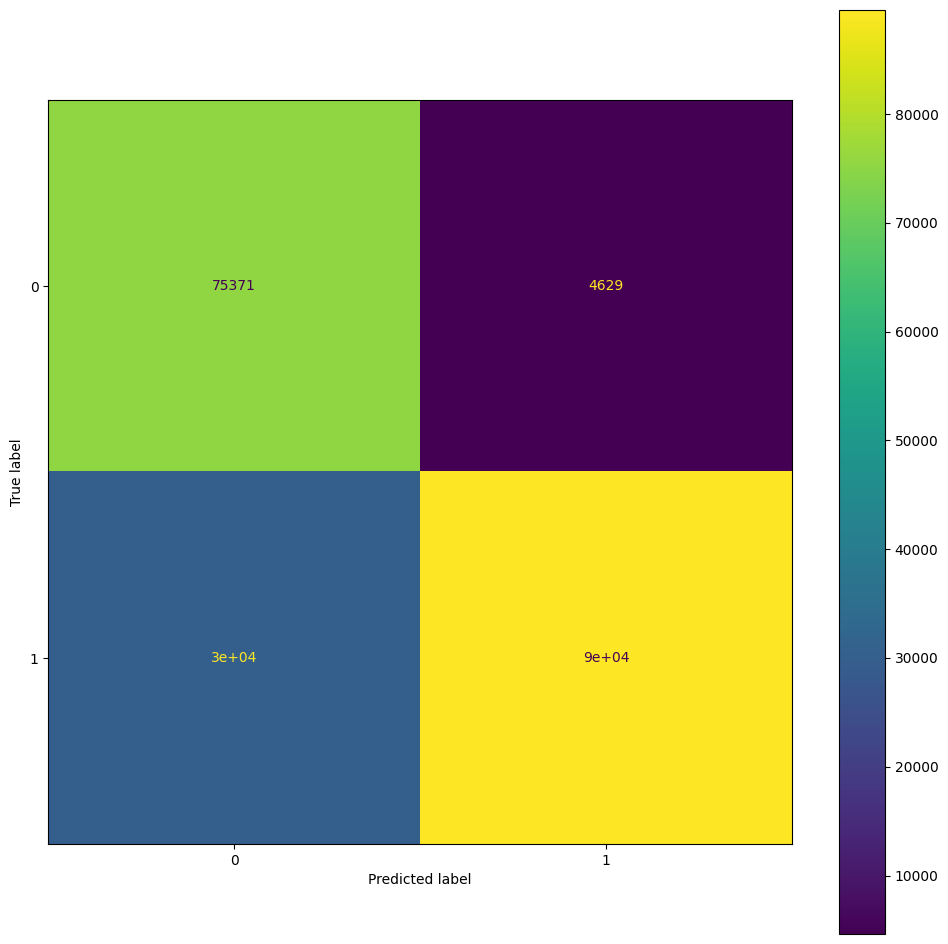

In [92]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
la_matriz=[0,1]
cm=confusion_matrix(X_['label'], X_['Trans_predict'])
disp = ConfusionMatrixDisplay(cm,display_labels=la_matriz)
fig, ax = plt.subplots(figsize=(12,12))
disp.plot(ax=ax)

In [93]:
print('= = ='*10,'12. Guardar el Modelo lof ')
pickle_model('lof__EJERCICIO10_n_components6_fit_over.pkl', 'wb', model)

= = == = == = == = == = == = == = == = == = == = = 12. Guardar el Modelo lof 
Modelo lof__EJERCICIO10_n_components6_fit_over.pkl guardado.


In [94]:
#23/11
#'list_lof_over.txt'
#lof_EJERCICIO10_.csv 

#df2.to_csv('lof_EJERCICIO10_over.csv')

In [95]:
#calcular los shap values
# Crear un objeto explainer de SHAP para LOF
lof_explainer = shap.Explainer(model_.fit_predict, X_Test.sample(500))

In [96]:
# Calcular los SHAP values LOF
lof_shap_values = lof_explainer(X_Test.sample(500))

Exact explainer: 501it [01:17,  5.89it/s]                         


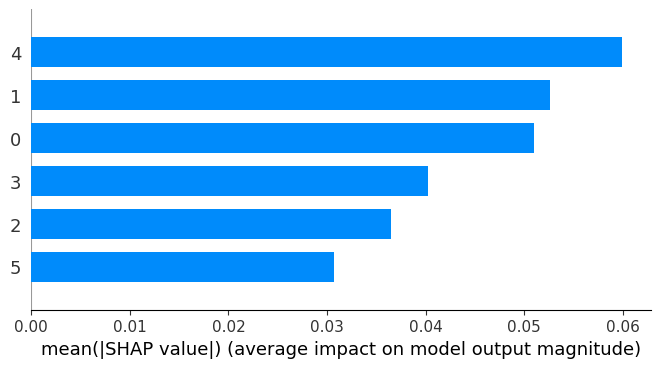

In [97]:
# Primera forma de visualizar los SHAP values LOF
shap.summary_plot(lof_shap_values, X_Test, plot_type='bar')

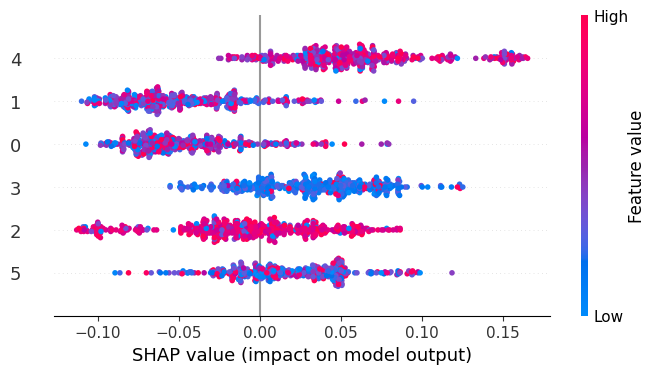

In [98]:
shap.summary_plot(lof_shap_values, X_Test.sample(500))

# Iforest
- Preparación de la data
- OrdinalEncoder
- StandardScaler
- SimpleImputer
- RandomOverSampler
- Seleccion y extracción de de caracteriticas por correlación
- PCA
- Isolation Forest

In [99]:
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.ensemble import IsolationForest
from matplotlib import pyplot
ifor_1 = Pipeline(steps=[('preprocessor_3_pca',preprocessor_3),
                           ('ifor',IsolationForest(max_samples=300, contamination=0.1))])
ifor_1

Pipeline(steps=[('preprocessor_3_pca',
                 Pipeline(steps=[('prepro_2_del',
                                  Pipeline(steps=[('prepro_1_num_cat',
                                                   ColumnTransformer(transformers=[('number',
                                                                                    Pipeline(steps=[('impute',
                                                                                                     SimpleImputer(fill_value=-1,
                                                                                                                   strategy='constant'))]),
                                                                                    ['delta_time',
                                                                                     'port_src',
                                                                                     'port_dst',
                                                                                     'frame_len',
                                                                                     'udp_len',
                                                                                     'ip_ttl',
                                                                                     'icmp_type',
                                                                                     'tos',
                                                                                     'ip_flags_rb',
                                                                                     'ip_flags_df',
                                                                                     'ip_flags_m...
                                                                        'number__tcp_flags_res',
                                                                        'number__tcp_flags_ns',
                                                                        'number__tcp_flags_cwr',
                                                                        'number__tcp_flags_ecn',
                                                                        'number__tcp_flags_urg',
                                                                        'number__tcp_flags_ack',
                                                                        'number__tcp_flags_push',
                                                                        'number__tcp_flags_reset',
                                                                        'number__tcp_flags_syn',
                                                                        'number__tcp_flags_fin']))])),
                                 ('scaler', StandardScaler()),
                                 ('pca', PCA(n_components=6))])),
                ('ifor', IsolationForest(contamination=0.1, max_samples=300))])

In [100]:
ind_train = df.loc[df['tipo_ataque'] == 'Normal'].index
cantidad = len(ind_train)*0.8
ind_train = ind_train[:int(cantidad)]

#print(cantidad)
X_train= df.loc[df['tipo_ataque'] == 'Normal'].head(int(cantidad)).drop(['label','tipo_ataque'],axis=1)
print(X_train.tail(5))
y_train = df.loc[df['tipo_ataque'] == 'Normal'].head(int(cantidad))['label']
print(y_train)

        delta_time protocols  port_src  port_dst  frame_len  udp_len  ip_ttl  \
86244     0.000003       UDP      80.0      80.0        750    716.0   127.0   
130553    0.002152       UDP      80.0      80.0        730    696.0   127.0   
7101      0.000002       TCP      80.0      80.0       1464      NaN   127.0   
67411     0.000005       TCP    8080.0      80.0        753      NaN   127.0   
68409     0.023831       TCP      80.0    8080.0        511      NaN   127.0   

        icmp_type  tos  ip_flags_rb  ip_flags_df  ip_flags_mf  tcp_flags_res  \
86244         NaN  0.0          0.0          0.0          0.0            NaN   
130553        NaN  0.0          0.0          0.0          0.0            NaN   
7101          NaN  0.0          0.0          0.0          0.0            0.0   
67411         NaN  0.0          0.0          0.0          0.0            0.0   
68409         NaN  0.0          0.0          0.0          0.0            0.0   

        tcp_flags_ns  tcp_flags_cwr  t

In [101]:
last_ind = ind_train[-1]
copy = df.loc[df['tipo_ataque'] == 'Normal'].loc[last_ind:].drop([last_ind],axis=0).index
ind_test = df.loc[df['tipo_ataque'] != 'Normal'].index
ind_test =ind_test.append(copy)
X_test = df.iloc[df.index.get_indexer(ind_test.difference(ind_train, sort=False))].drop(['label','tipo_ataque'],axis=1)
print(X_test.head(5))
y_test = df.iloc[df.index.get_indexer(ind_test.difference(ind_train, sort=False))]['label']
print(y_test.head(5))

        delta_time protocols  port_src  port_dst  frame_len  udp_len  ip_ttl  \
208905    0.000084      ICMP   35008.0    1051.0         70      8.0   64.47   
299463    0.000001       TCP   58470.0      80.0        154      NaN   64.00   
215553    0.000000       TCP   55267.0    2967.0         60      NaN   59.00   
314756    0.000000       UDP   30978.0      80.0         60      8.0   64.00   
245883    0.000001       UDP    8755.0      80.0         60      8.0   64.00   

        icmp_type   tos  ip_flags_rb  ip_flags_df  ip_flags_mf  tcp_flags_res  \
208905        3.0  48.0          0.0          0.0          0.0            NaN   
299463        NaN   0.0          0.0          0.0          0.0            0.0   
215553        NaN   0.0          0.0          0.0          0.0            0.0   
314756        NaN   0.0          0.0          0.0          0.0            NaN   
245883        NaN   0.0          0.0          0.0          0.0            NaN   

        tcp_flags_ns  tcp_flags_

In [102]:
model = ifor_1.fit(X_train)
model

Pipeline(steps=[('preprocessor_3_pca',
                 Pipeline(steps=[('prepro_2_del',
                                  Pipeline(steps=[('prepro_1_num_cat',
                                                   ColumnTransformer(transformers=[('number',
                                                                                    Pipeline(steps=[('impute',
                                                                                                     SimpleImputer(fill_value=-1,
                                                                                                                   strategy='constant'))]),
                                                                                    ['delta_time',
                                                                                     'port_src',
                                                                                     'port_dst',
                                                                                     'frame_len',
                                                                                     'udp_len',
                                                                                     'ip_ttl',
                                                                                     'icmp_type',
                                                                                     'tos',
                                                                                     'ip_flags_rb',
                                                                                     'ip_flags_df',
                                                                                     'ip_flags_m...
                                                                        'number__tcp_flags_res',
                                                                        'number__tcp_flags_ns',
                                                                        'number__tcp_flags_cwr',
                                                                        'number__tcp_flags_ecn',
                                                                        'number__tcp_flags_urg',
                                                                        'number__tcp_flags_ack',
                                                                        'number__tcp_flags_push',
                                                                        'number__tcp_flags_reset',
                                                                        'number__tcp_flags_syn',
                                                                        'number__tcp_flags_fin']))])),
                                 ('scaler', StandardScaler()),
                                 ('pca', PCA(n_components=6))])),
                ('ifor', IsolationForest(contamination=0.1, max_samples=300))])

In [103]:
test_scores = ifor_1.predict(X_test)
print(test_scores)
# Predict the labels (1 inlier, -1 outlier) of X according to LOF.
n_error_outliers = test_scores[test_scores == -1].size
n_error_test = test_scores[test_scores == 1].size
print(f'n_error_test {n_error_test}')
print(f'n_error_outliers {n_error_outliers}')

[-1 -1 -1 ...  1  1  1]
n_error_test 36080
n_error_outliers 123920


In [104]:
# NOTA
y_test.value_counts()

1    120000
0     40000
Name: label, dtype: int64

In [105]:
X_test['Trans_predict'] = test_scores
X_test

,delta_time,protocols,port_src,port_dst,frame_len,udp_len,ip_ttl,icmp_type,tos,ip_flags_rb,ip_flags_df,ip_flags_mf,tcp_flags_res,tcp_flags_ns,tcp_flags_cwr,tcp_flags_ecn,tcp_flags_urg,tcp_flags_ack,tcp_flags_push,tcp_flags_reset,tcp_flags_syn,tcp_flags_fin,Trans_predict
208905,0.000084,ICMP,35008.0,1051.0,70,8.0,64.47,3.0,48.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
299463,0.000001,TCP,58470.0,80.0,154,NaN,64.00,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1
215553,0.000000,TCP,55267.0,2967.0,60,NaN,59.00,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1
314756,0.000000,UDP,30978.0,80.0,60,8.0,64.00,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
245883,0.000001,UDP,8755.0,80.0,60,8.0,64.00,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34840,0.057730,TCP,80.0,8080.0,511,NaN,127.00,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
164538,0.000010,TCP,8080.0,80.0,1320,NaN,127.00,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
196149,0.001708,TCP,8080.0,80.0,907,NaN,127.00,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
123714,0.000002,UDP,80.0,80.0,600,566.0,127.00,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [106]:
X_test['Trans_predict'] = X_test['Trans_predict'].mask(X_test['Trans_predict'] == 1,0)
X_test['Trans_predict'] = X_test['Trans_predict'].mask(X_test['Trans_predict'] == -1,1)
X_test['Trans_predict']

208905    1
299463    1
215553    1
314756    1
245883    1
         ..
34840     1
164538    0
196149    0
123714    0
194602    0
Name: Trans_predict, Length: 160000, dtype: int64

In [107]:
pp1_=preprocessor_2.fit_transform(X_test)
pp1_.index = X_test.index
pp1_

,number__delta_time,number__port_src,number__port_dst,number__frame_len,number__udp_len,number__ip_ttl,number__tos,number__ip_flags_df,number__ip_flags_mf,number__tcp_flags_ns,number__tcp_flags_syn
208905,0.000084,35008.0,1051.0,70.0,8.0,64.47,48.0,0.0,0.0,-1.0,-1.0
299463,0.000001,58470.0,80.0,154.0,-1.0,64.00,0.0,0.0,0.0,0.0,1.0
215553,0.000000,55267.0,2967.0,60.0,-1.0,59.00,0.0,0.0,0.0,0.0,1.0
314756,0.000000,30978.0,80.0,60.0,8.0,64.00,0.0,0.0,0.0,-1.0,-1.0
245883,0.000001,8755.0,80.0,60.0,8.0,64.00,0.0,0.0,0.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...
34840,0.057730,80.0,8080.0,511.0,-1.0,127.00,0.0,0.0,0.0,0.0,0.0
164538,0.000010,8080.0,80.0,1320.0,-1.0,127.00,0.0,0.0,0.0,0.0,0.0
196149,0.001708,8080.0,80.0,907.0,-1.0,127.00,0.0,0.0,0.0,0.0,0.0
123714,0.000002,80.0,80.0,600.0,566.0,127.00,0.0,0.0,0.0,-1.0,-1.0


In [108]:
X_ = pd.concat([pp1_,X_test['Trans_predict'],y_test],axis=1)
X_.head(5)

,number__delta_time,number__port_src,number__port_dst,number__frame_len,number__udp_len,number__ip_ttl,number__tos,number__ip_flags_df,number__ip_flags_mf,number__tcp_flags_ns,number__tcp_flags_syn,Trans_predict,label
208905,0.000084,35008.0,1051.0,70.0,8.0,64.47,48.0,0.0,0.0,-1.0,-1.0,1,1
299463,0.000001,58470.0,80.0,154.0,-1.0,64.00,0.0,0.0,0.0,0.0,1.0,1,1
215553,0.000000,55267.0,2967.0,60.0,-1.0,59.00,0.0,0.0,0.0,0.0,1.0,1,1
314756,0.000000,30978.0,80.0,60.0,8.0,64.00,0.0,0.0,0.0,-1.0,-1.0,1,1
245883,0.000001,8755.0,80.0,60.0,8.0,64.00,0.0,0.0,0.0,-1.0,-1.0,1,1


In [109]:
metricas.metricas(X_,'label','Trans_predict')
print('Rendimiento de Gastos Generales:')
print(f"tiempo:--- {time.time() - start_time} Segundos ---")
print('tiempo_cpu', t_cpu)
print('%_cpu', '%.2f%%' % cpu_usage)
print('%_mem', '%.2f%%' % mem_usage)
print ('consumo de disco', '%.2f%%' % disco2[3])

              precision    recall  f1-score   support

           0       1.00      0.90      0.95     40000
           1       0.97      1.00      0.98    120000

    accuracy                           0.98    160000
   macro avg       0.98      0.95      0.97    160000
weighted avg       0.98      0.98      0.97    160000

Purity  0.97542
homogeneity_score:  0.80579
completeness_score:  0.84889
v_measure_score:  0.82678
adjusted_mutual_info_score:  0.82678
Rendimiento de Gastos Generales:
tiempo:--- 21361.27951645851 Segundos ---
tiempo_cpu scputimes(user=288.8, nice=452.9, system=512.32, idle=15134.9, iowait=199.64, irq=0.0, softirq=25.6, steal=0.0, guest=0.0, guest_nice=0.0)
%_cpu 6.50%
%_mem 7.20%
consumo de disco 46.50%


In [110]:
matriz1=metricas.matriz(X_,'label', 'Trans_predict')
matriz1[0]


1
         Positive Negative
Positive   119994        6
Negative     3926    36074

0
         Positive Negative
Positive    36074     3926
Negative        6   119994


,Cantidad,coincidencia,% prediccion,total prediciones
0,120000,119994,0.99995,123920
1,40000,36074,0.90185,36080


In [111]:
matriz1[1]

,tp,fp,fn,tn,tp+fn,tp+fp,fn+tn,fp+tn,recall,precision,F1
1,119994,3926,6,36074,120000,123920,36080,40000,0.99995,0.968318,0.98388
0,36074,6,3926,119994,40000,36080,123920,120000,0.90185,0.999834,0.948318


In [112]:
# datos para realizar las metricas internas
preprocessor_3.fit(X_test)
pp3 = preprocessor_3.transform(X_test)
# #Con PCA
pp3 = pd.DataFrame(pp3, index=X_test.index)
# #Sin PCA
# pp3 = pd.DataFrame(pp3, index=X.index,columns=pp1.columns)
pp3

,0,1,2,3,4,5
208905,0.099807,3.826090,0.984079,-0.167717,-3.128293,-2.257768
299463,-1.777101,-0.795213,-0.449730,-0.068691,-0.394791,-0.266796
215553,-1.901050,-0.601923,-0.327916,-0.040334,-0.343277,-0.192226
314756,0.220084,1.410184,-0.762877,-0.210913,0.702187,0.112189
245883,0.724403,1.367715,-0.730868,-0.155243,0.874305,0.202925
...,...,...,...,...,...,...
34840,1.681803,-1.593074,2.596414,3.429924,2.119811,-1.424943
164538,1.961824,-2.150800,0.261621,0.156225,-0.641995,-0.374602
196149,1.536108,-1.753312,0.191948,0.197369,-0.325724,-0.322916
123714,3.176284,0.045785,-0.297101,-0.528125,-0.143316,0.271147


In [113]:
chs,dbs=metricas.metrica_internas(pp3,X_['Trans_predict'])
print(f'Calinski: {chs}')
print(f'Davies: {dbs}')

Calinski: 55809.80451
Davies: 1.11896


In [114]:
model_ = IsolationForest(n_estimators=300, max_samples=300, contamination=0.1)
model_.fit(X_Train) 
y_pred_ifo = model_.predict(X_Test)

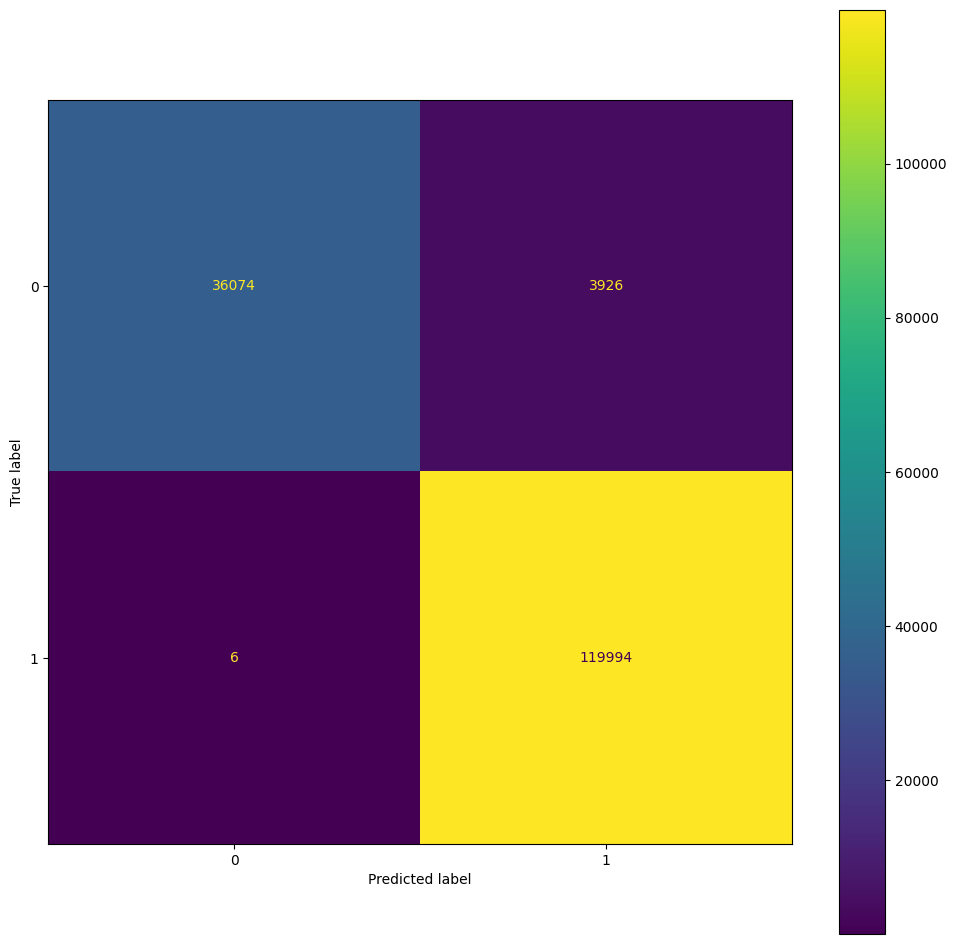

In [115]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
la_matriz=[0,1]
cm=confusion_matrix(X_['label'], X_['Trans_predict'])
disp = ConfusionMatrixDisplay(cm,display_labels=la_matriz)
fig, ax = plt.subplots(figsize=(12,12))
disp.plot(ax=ax)

In [116]:
# Explicabilidad con TreeShap
Ifor_explainer = shap.Explainer(model_.fit_predict, X_Test.sample(500))

In [117]:
#Calcular los Shap Values
Ifor_shap_values = Ifor_explainer(X_Test.sample(500))

Exact explainer: 501it [09:46,  1.19s/it]                         


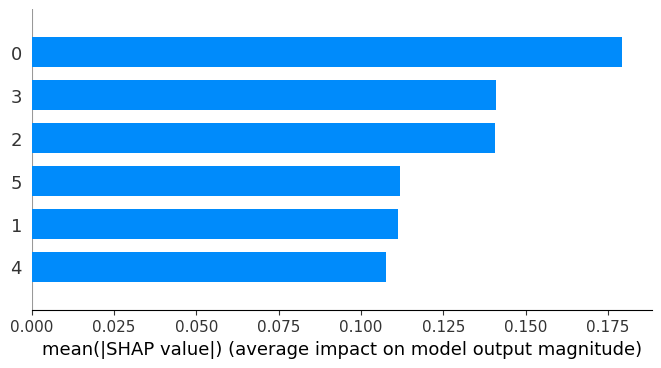

In [118]:
# Primera forma de visualizar los SHAP values kMeans
shap.summary_plot(Ifor_shap_values, X_Test, plot_type='bar')

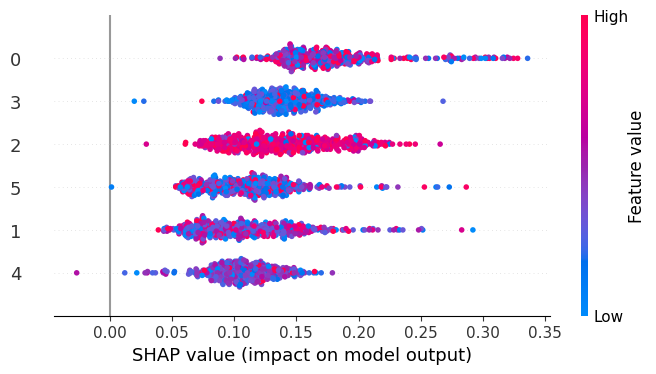

In [119]:
# Segunda Forma de Calcular los SHAP values LOF
shap.summary_plot(Ifor_shap_values, X_Test.sample(500))

In [120]:
#print('= = ='*10,'12. Guardar el Modelo iforest ')
#pickle_model('iforest__EJERCICIO10_n_components6_fit.pkl', 'wb', model)

In [121]:
#23/11
#'list_iforest.txt' 'list_lof.txt'
#ifores_EJERCICIO10_.csv 

# df2.to_csv('iforest_EJERCICIO10_.csv')